In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [4]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [5]:
signnames

ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                               Stop
15       15                                        No vehicles
16       16           Vehicles over 3.5 metric tons prohibited
17       17                                           No entry
18       18                                    General caution
19       19                        Dangerous curve to the left
20       20                       Dangerous curve to the right
21       21                                       Double curve
22       22                                         Bumpy road
23       23                                      Slippery road
24       24                          Road narrows on the right
25       25                                          Road work
26       26                                    Traffic signals
27       27                                        Pedestrians
28       28                                  Children crossing
29       29                                  Bicycles crossing
30       30                                 Beware of ice/snow
31       31                              Wild animals crossing
32       32                End of all speed and passing limits
33       33                                   Turn right ahead
34       34                                    Turn left ahead
35       35                                         Ahead only
36       36                               Go straight or right
37       37                                Go straight or left
38       38                                         Keep right
39       39                                          Keep left
40       40                               Roundabout mandatory
41       41                                  End of no passing
42       42  End of no passing by vehicles over 3.5 metric ...

--- 
Load and test the model from GTSRB_Keras_STN   
https://github.com/hello2all/GTSRB_Keras_STN

In [6]:
# model = conv_model()
model = conv_model_no_color_adjust()
model.load_weights("./keras_weights/stn_v5.hdf5")

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
spatial_transformer_1 (Spati (None, 32, 32, 3)         294794    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
__________

In [8]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))
print(model.evaluate(X_val, y_val))

34799/34799 [==============================] - 15s 428us/step
[0.02392977455228866, 1.0]
12630/12630 [==============================] - 5s 404us/step
[0.07372288382298778, 0.9922406967254451]
4410/4410 [==============================] - 2s 417us/step
[0.04401305044183926, 0.9975056689342403]


In [35]:
get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])

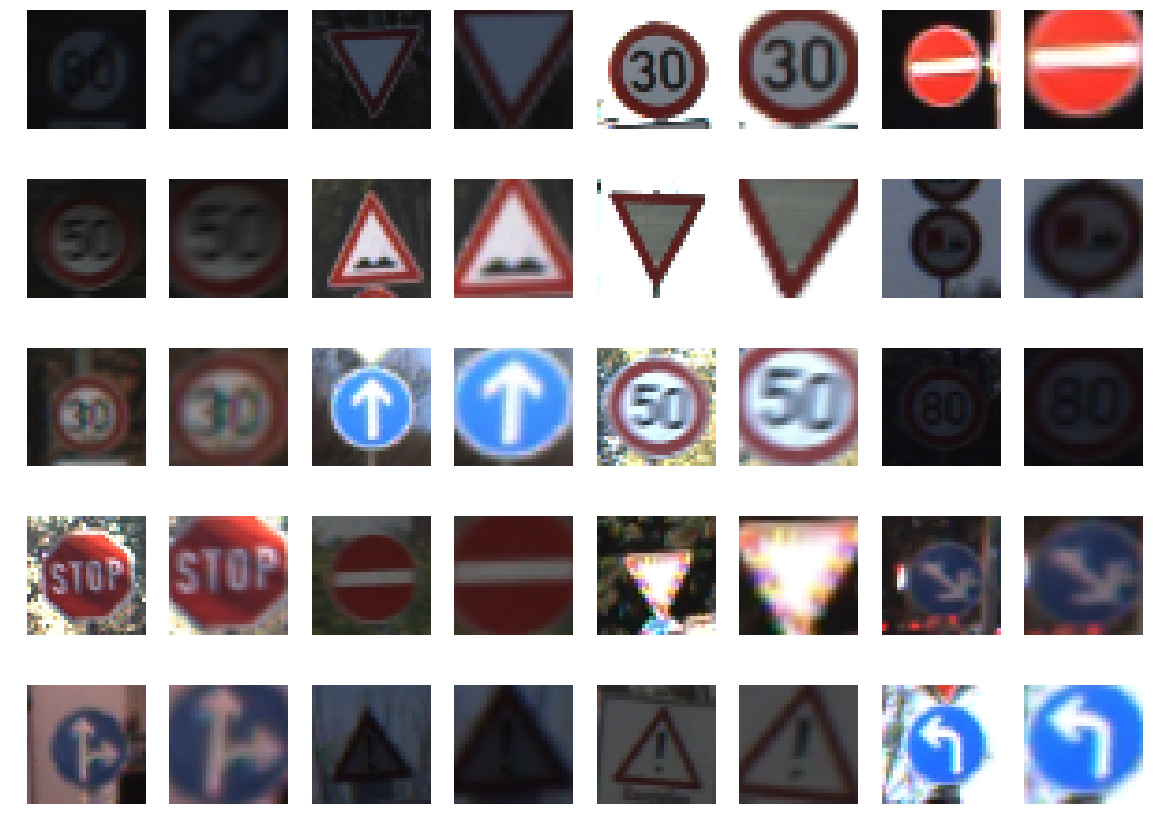

In [36]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 15))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    ax[ii, jj + 1].imshow(stn_output[0]/2 + 0.5)
    ax[ii, jj + 1].axis("off")

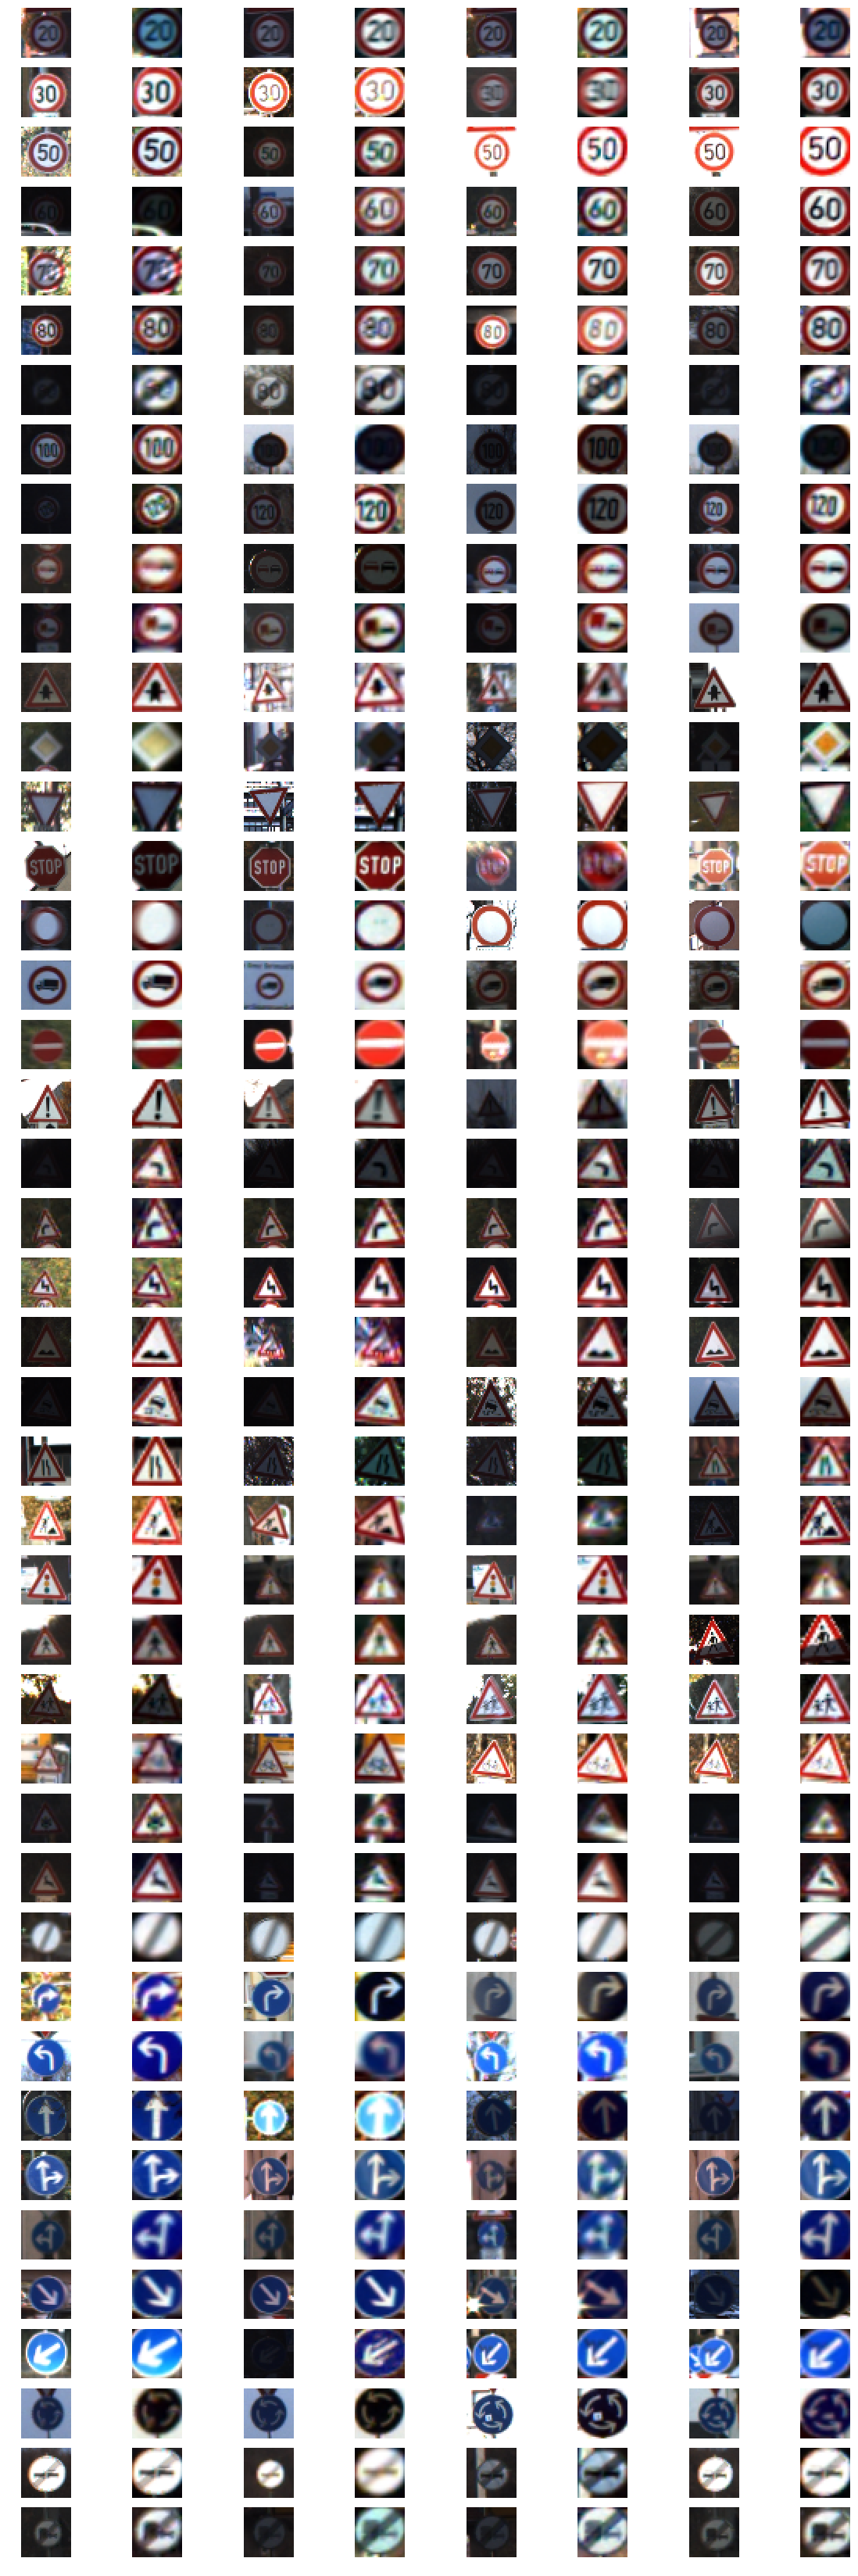

In [37]:
X = X_test
y = y_test

f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
for i in range(NUM_LABELS):
    
    ind = np.where(y == i)
    for j in range(4):

        x = X[ind][j]
        ax[i, j*2].imshow(x)
        ax[i, j*2].axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
        for c in range(3):
            x_c = x[:, :, c]
            x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax[i, j*2 + 1].imshow(x)
        ax[i, j*2 + 1].axis("off")

In [8]:
model.layers[8].locnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

--- 

In [9]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

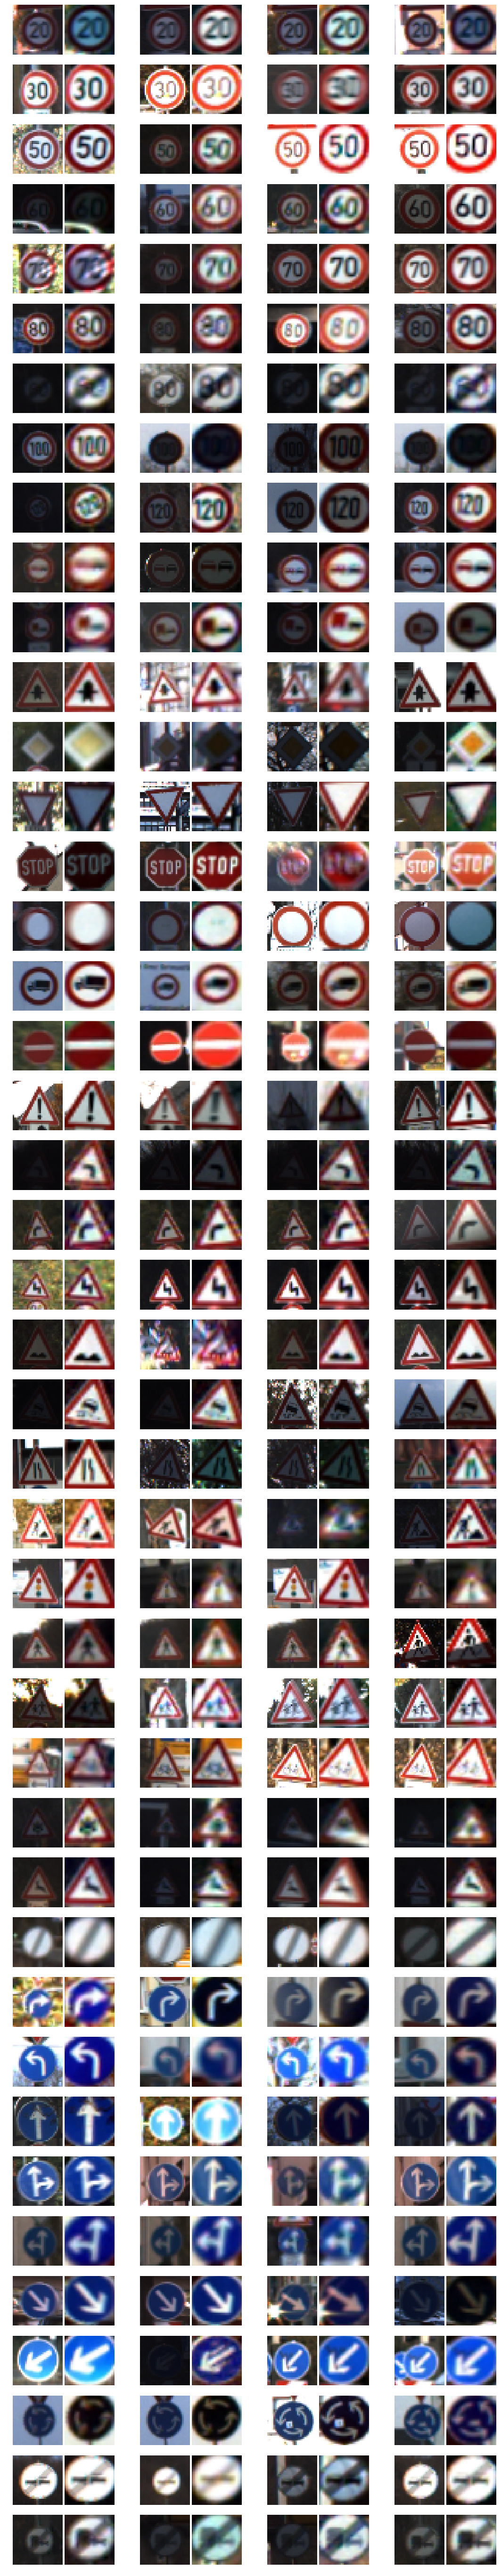

In [43]:
X = X_test
y = y_test

# f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
fig = plt.figure(figsize=(15, 100))

for j in range(4):
    
    left = j*0.25 + 0.05
    right = j*0.25 + 0.25
    gs = GridSpec(NUM_LABELS, 2)
    gs.update(left=left, right=right, wspace=0.05)
    for i in range(NUM_LABELS):

        ind = np.where(y == i)
        ax1 = plt.subplot(gs[i, 0])
        ax2 = plt.subplot(gs[i, 1])
        
        x = X[ind][j]
        ax1.imshow(x)
        ax1.axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
        for c in range(3):
            x_c = x[:, :, c]
            x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax2.imshow(x)
        ax2.axis("off")
        
plt.savefig("stn_v3.png", bbox_inches="tight")

In [10]:
get_st_params = K.function([model.layers[1].locnet.input, K.learning_phase()],
                           [model.layers[1].locnet.output])

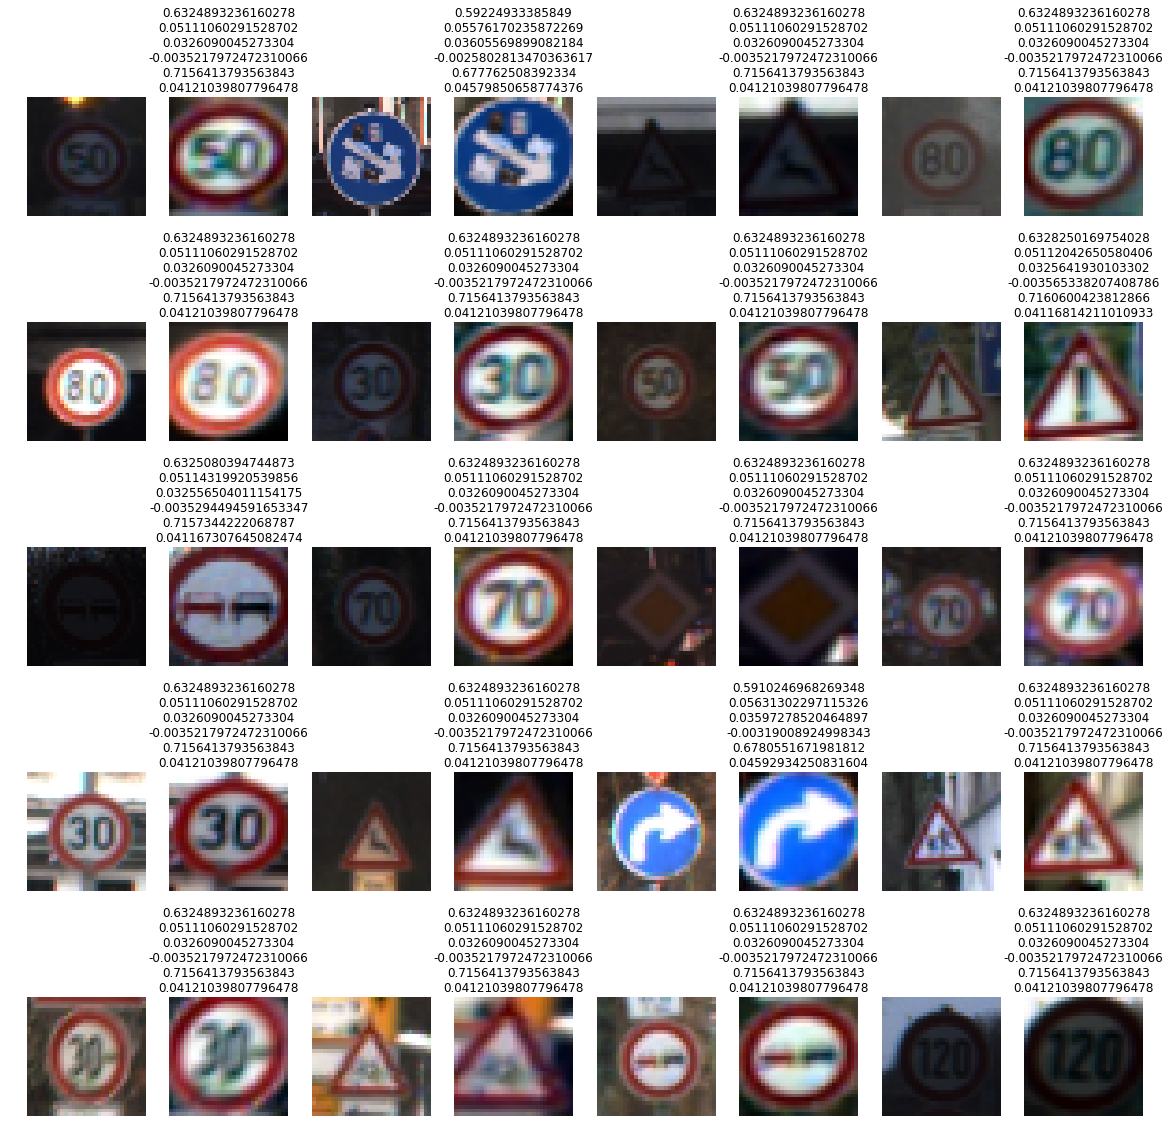

In [11]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    param = get_st_params([x[np.newaxis, :], 0])[0]
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])
    # x = (x - x.min())/(x.max() - x.min())
    for c in range(3):
        x_c = x[:, :, c]
        x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")
    ax[ii, jj + 1].set_title("{}\n{}\n{}\n{}\n{}\n{}".format(*param[0]))

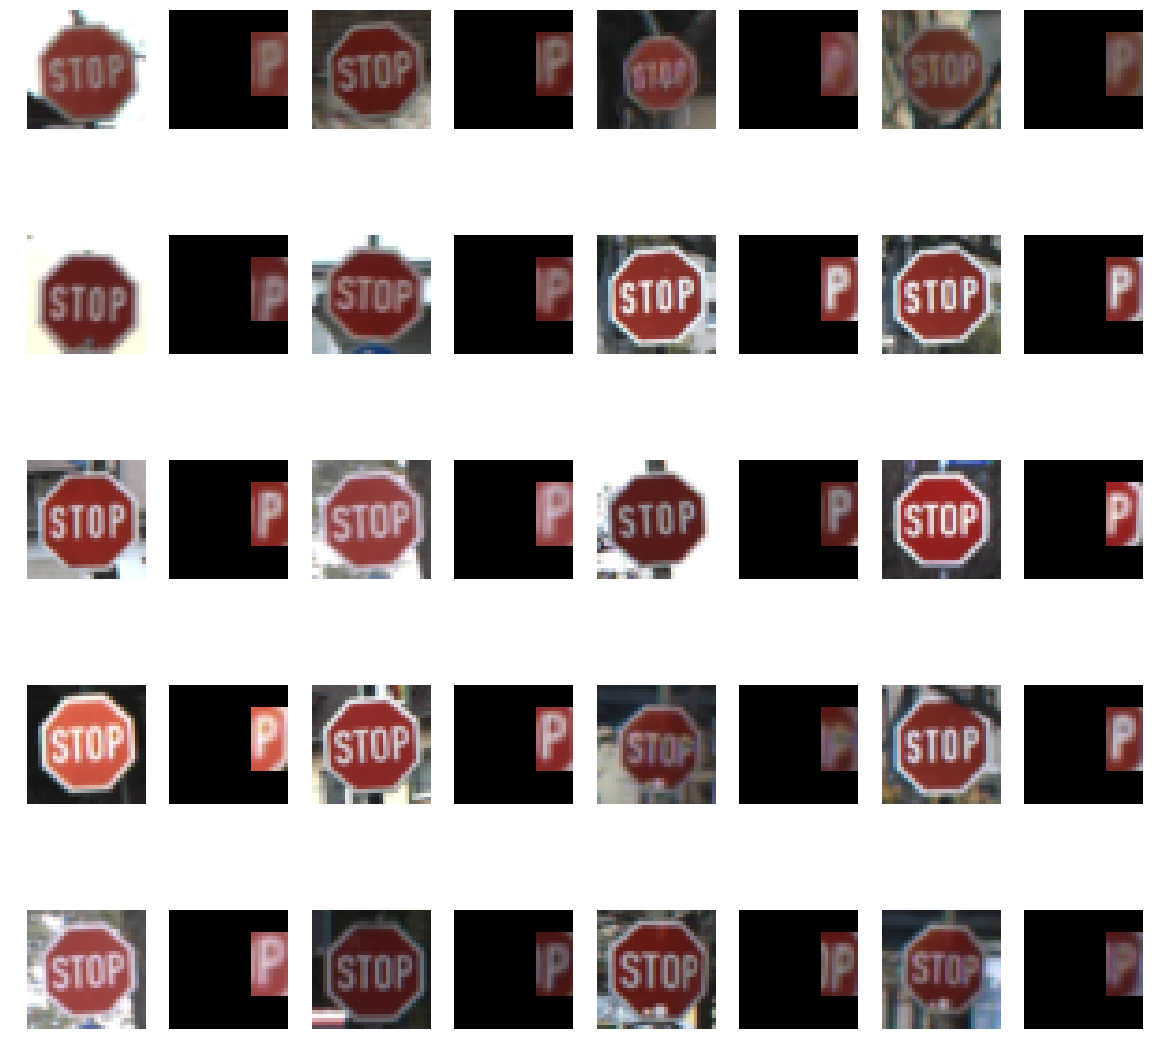

In [28]:
X = X_train
y = y_train
n = 20
y_label = 14
top, bot, left, right = 6, 23, 22, 32
ind = np.where(y == y_label)[0]
random.shuffle(ind)

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[ind][i]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])*0.5 + 0.5
    # x = (x - x.min())/(x.max() - x.min())
#     for c in range(3):
#         x_c = x[:, :, c]
#         x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
#     ax[ii, jj].imshow(x)
#     ax[ii, jj].axis("off")
    
    x[:top, :] = 0
    x[bot:, :] = 0
    x[:, :left] = 0
    x[:, right:] = 0
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")

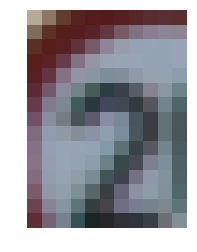

In [6]:
# crop '2': pos = 8, 23, 8, 17
# crop 'S': pos = 9, 23, 1, 9

def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Test get_patch
X_2 = get_patch(X_train, (7, 22, 7, 18))
plt.imshow(X_2[np.where(y_train == 0)][0])
plt.axis("off")
plt.show()

In [7]:
# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

---
## Train/test small CNN

In [37]:
model_0 = train_simple_cnn(stn_weight, pos_0, [0, 1, 2, 3, 4, 5], 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/0.hdf5")

Epoch 1/40
406/405 [==============================] - 23s 57ms/step - loss: 0.4345 - acc: 0.7904 - val_loss: 0.1348 - val_acc: 0.9425

Epoch 00001: val_loss improved from inf to 0.13480, saving model to ./keras_weights/0.hdf5
Epoch 2/40
406/405 [==============================] - 22s 55ms/step - loss: 0.2589 - acc: 0.8889 - val_loss: 0.0901 - val_acc: 0.9682

Epoch 00002: val_loss improved from 0.13480 to 0.09006, saving model to ./keras_weights/0.hdf5
Epoch 3/40
406/405 [==============================] - 23s 55ms/step - loss: 0.1960 - acc: 0.9192 - val_loss: 0.0709 - val_acc: 0.9757

Epoch 00003: val_loss improved from 0.09006 to 0.07089, saving model to ./keras_weights/0.hdf5
Epoch 4/40
406/405 [==============================] - 24s 59ms/step - loss: 0.1662 - acc: 0.9327 - val_loss: 0.0515 - val_acc: 0.9854

Epoch 00004: val_loss improved from 0.07089 to 0.05153, saving model to ./keras_weights/0.hdf5
Epoch 5/40
406/405 [==============================] - 23s 58ms/step - loss: 0.1431 -

In [40]:
# 
print(eval_simple_cnn(model_0, [0, 1, 2, 3, 4, 5], X_train, y_train))
print(eval_simple_cnn(model_0, [0, 1, 2, 3, 4, 5], X_val, y_val))
print(eval_simple_cnn(model_0, [0, 1, 2, 3, 4, 5], X_test, y_test))

(0.9964941521308084, 0.0028902847893945817, 0.005310734463276836)
(0.9943310657596371, 0.0036036036036036037, 0.012037037037037037)
(0.9860649247822645, 0.014743589743589743, 0.011620795107033639)


In [91]:
model_y11 = train_simple_cnn(stn_weight, pos_y11, 11, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/rightway.hdf5")

Train on 34799 samples, validate on 4410 samples
Epoch 1/40
34799/34799 [==============================] - 5s 153us/step - loss: 0.1692 - acc: 0.9401 - val_loss: 0.0432 - val_acc: 0.9862

Epoch 00001: val_loss improved from inf to 0.04320, saving model to ./keras_weights/rightway.hdf5
Epoch 2/40
34799/34799 [==============================] - 3s 87us/step - loss: 0.0675 - acc: 0.9817 - val_loss: 0.0358 - val_acc: 0.9875

Epoch 00002: val_loss improved from 0.04320 to 0.03584, saving model to ./keras_weights/rightway.hdf5
Epoch 3/40
34799/34799 [==============================] - 3s 87us/step - loss: 0.0546 - acc: 0.9861 - val_loss: 0.0308 - val_acc: 0.9896

Epoch 00003: val_loss improved from 0.03584 to 0.03085, saving model to ./keras_weights/rightway.hdf5
Epoch 4/40
34799/34799 [==============================] - 3s 87us/step - loss: 0.0496 - acc: 0.9879 - val_loss: 0.0266 - val_acc: 0.9912

Epoch 00004: val_loss improved from 0.03085 to 0.02655, saving model to ./keras_weights/rightway

In [93]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_y11, get_stn_output, 11, X_train, y_train))
print(eval_simple_cnn(model_y11, get_stn_output, 11, X_val, y_val))
print(eval_simple_cnn(model_y11, get_stn_output, 11, X_test, y_test))

(0.9927009396821748, 0.007285378691010735, 0.007692307692307693)
(0.9877551020408163, 0.01267605633802817, 0.0)
(0.9865399841646872, 0.011547911547911549, 0.06904761904761905)


In [32]:
# model_3 = train_simple_cnn(stn_weight, pos_3, 1, 
#                            X_train, y_train, 
#                            X_val, y_val,
#                            save_path="./keras_weights/1_3.hdf5")
model_3 = train_simple_cnn(stn_weight, pos_3, 1, 
                           X_train, y_train, 
                           X_val, y_val)

Epoch 1/40
544/543 [==============================] - 32s 60ms/step - loss: 0.3782 - acc: 0.8368 - val_loss: 0.0889 - val_acc: 0.9712

Epoch 00001: val_loss improved from inf to 0.08894, saving model to ./keras_weights/temp.hdf5
Epoch 2/40
544/543 [==============================] - 32s 59ms/step - loss: 0.1902 - acc: 0.9263 - val_loss: 0.0503 - val_acc: 0.9814

Epoch 00002: val_loss improved from 0.08894 to 0.05028, saving model to ./keras_weights/temp.hdf5
Epoch 3/40
544/543 [==============================] - 33s 62ms/step - loss: 0.1271 - acc: 0.9540 - val_loss: 0.0249 - val_acc: 0.9948

Epoch 00003: val_loss improved from 0.05028 to 0.02486, saving model to ./keras_weights/temp.hdf5
Epoch 4/40
544/543 [==============================] - 31s 57ms/step - loss: 0.0927 - acc: 0.9670 - val_loss: 0.0225 - val_acc: 0.9912

Epoch 00004: val_loss improved from 0.02486 to 0.02254, saving model to ./keras_weights/temp.hdf5
Epoch 5/40
544/543 [==============================] - 32s 59ms/step - lo

In [49]:
# 
print(eval_simple_cnn(model_3, get_stn_output, 1, X_train, y_train))
print(eval_simple_cnn(model_3, get_stn_output, 1, X_val, y_val))
print(eval_simple_cnn(model_3, get_stn_output, 1, X_test, y_test))

(0.9989080145981206, 0.0011578658703799629, 0.0)
(0.9970521541950114, 0.0028776978417266188, 0.004166666666666667)
(0.9956452889944576, 0.004030226700251889, 0.009722222222222222)


In [33]:
# 
print(eval_simple_cnn(model_3, get_stn_output, 1, X_train, y_train))
print(eval_simple_cnn(model_3, get_stn_output, 1, X_val, y_val))
print(eval_simple_cnn(model_3, get_stn_output, 1, X_test, y_test))

(0.9970976177476364, 0.002986075139400957, 0.0015151515151515152)
(0.9913832199546485, 0.009112709832134292, 0.0)
(0.9861441013460016, 0.014441645675902602, 0.004166666666666667)


In [28]:
# model_S = train_simple_cnn(stn_weight, pos_S, 14, 
#                            X_train, y_train, 
#                            X_val, y_val,
#                            save_path="./keras_weights/14_S.hdf5")
model_S = train_simple_cnn(stn_weight, pos_S, 14, 
                           X_train, y_train, 
                           X_val, y_val)

Epoch 1/40
544/543 [==============================] - 33s 61ms/step - loss: 0.1394 - acc: 0.9464 - val_loss: 0.0142 - val_acc: 0.9961

Epoch 00001: val_loss improved from inf to 0.01419, saving model to ./keras_weights/temp.hdf5
Epoch 2/40
544/543 [==============================] - 31s 56ms/step - loss: 0.0418 - acc: 0.9856 - val_loss: 0.0095 - val_acc: 0.9966

Epoch 00002: val_loss improved from 0.01419 to 0.00946, saving model to ./keras_weights/temp.hdf5
Epoch 3/40
544/543 [==============================] - 31s 58ms/step - loss: 0.0295 - acc: 0.9898 - val_loss: 0.0082 - val_acc: 0.9967

Epoch 00003: val_loss improved from 0.00946 to 0.00825, saving model to ./keras_weights/temp.hdf5
Epoch 4/40
544/543 [==============================] - 30s 55ms/step - loss: 0.0207 - acc: 0.9928 - val_loss: 0.0109 - val_acc: 0.9927

Epoch 00004: val_loss did not improve from 0.00825
Epoch 5/40
544/543 [==============================] - 32s 59ms/step - loss: 0.0191 - acc: 0.9930 - val_loss: 0.0085 - v

In [29]:
# best
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9999425270841116, 5.8635550734410276e-05, 0.0)
(1.0, 0.0, 0.0)
(0.9989707046714172, 0.000970873786407767, 0.003703703703703704)


In [74]:
# ***** transfer, eq (r=3), lr 1e-4
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9963792062990315, 0.003606086370166232, 0.004347826086956522)
(0.992517006802721, 0.00625, 0.06666666666666667)
(0.9932699920823437, 0.005906148867313916, 0.044444444444444446)


In [64]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9891376188970947, 0.011082119088803542, 0.0)
(0.9752834467120182, 0.024537037037037038, 0.03333333333333333)
(0.9889944576405384, 0.010922330097087379, 0.014814814814814815)


In [41]:
model_T = train_simple_cnn(stn_weight, pos_T, [14], 
                           X_train, y_train, 
                           X_val, y_val)
print(eval_simple_cnn(model_T, [14], X_train, y_train))
print(eval_simple_cnn(model_T, [14], X_val, y_val))
print(eval_simple_cnn(model_T, [14], X_test, y_test))

Epoch 1/40
533/532 [==============================] - 31s 59ms/step - loss: 0.1303 - acc: 0.9510 - val_loss: 0.0183 - val_acc: 0.9926

Epoch 00001: val_loss improved from inf to 0.01828, saving model to ./keras_weights/temp.hdf5
Epoch 2/40
533/532 [==============================] - 31s 58ms/step - loss: 0.0400 - acc: 0.9866 - val_loss: 0.0119 - val_acc: 0.9962

Epoch 00002: val_loss improved from 0.01828 to 0.01191, saving model to ./keras_weights/temp.hdf5
Epoch 3/40
533/532 [==============================] - 30s 55ms/step - loss: 0.0288 - acc: 0.9903 - val_loss: 0.0123 - val_acc: 0.9940

Epoch 00003: val_loss did not improve from 0.01191
Epoch 4/40
533/532 [==============================] - 30s 57ms/step - loss: 0.0238 - acc: 0.9915 - val_loss: 0.0026 - val_acc: 0.9997

Epoch 00004: val_loss improved from 0.01191 to 0.00265, saving model to ./keras_weights/temp.hdf5
Epoch 5/40
533/532 [==============================] - 30s 56ms/step - loss: 0.0192 - acc: 0.9932 - val_loss: 0.0071 - v

In [42]:
model_O = train_simple_cnn(stn_weight, pos_O, [14], 
                           X_train, y_train, 
                           X_val, y_val)
print(eval_simple_cnn(model_O, [14], X_train, y_train))
print(eval_simple_cnn(model_O, [14], X_val, y_val))
print(eval_simple_cnn(model_O, [14], X_test, y_test))

Epoch 1/40
533/532 [==============================] - 31s 59ms/step - loss: 0.1087 - acc: 0.9590 - val_loss: 0.0183 - val_acc: 0.9928

Epoch 00001: val_loss improved from inf to 0.01826, saving model to ./keras_weights/temp.hdf5
Epoch 2/40
533/532 [==============================] - 30s 56ms/step - loss: 0.0327 - acc: 0.9886 - val_loss: 0.0107 - val_acc: 0.9939

Epoch 00002: val_loss improved from 0.01826 to 0.01070, saving model to ./keras_weights/temp.hdf5
Epoch 3/40
533/532 [==============================] - 32s 59ms/step - loss: 0.0239 - acc: 0.9918 - val_loss: 0.0220 - val_acc: 0.9934

Epoch 00003: val_loss did not improve from 0.01070
Epoch 4/40
533/532 [==============================] - 31s 57ms/step - loss: 0.0178 - acc: 0.9938 - val_loss: 0.0088 - val_acc: 0.9941

Epoch 00004: val_loss improved from 0.01070 to 0.00882, saving model to ./keras_weights/temp.hdf5
Epoch 5/40
533/532 [==============================] - 30s 56ms/step - loss: 0.0153 - acc: 0.9946 - val_loss: 0.0047 - v

In [44]:
model_P = train_simple_cnn(stn_weight, pos_P, [14], 
                           X_train, y_train, 
                           X_val, y_val)
print(eval_simple_cnn(model_P, [14], X_train, y_train))
print(eval_simple_cnn(model_P, [14], X_val, y_val))
print(eval_simple_cnn(model_P, [14], X_test, y_test))

Epoch 1/40
533/532 [==============================] - 32s 60ms/step - loss: 0.1500 - acc: 0.9445 - val_loss: 0.0521 - val_acc: 0.9854

Epoch 00001: val_loss improved from inf to 0.05215, saving model to ./keras_weights/temp.hdf5
Epoch 2/40
533/532 [==============================] - 30s 57ms/step - loss: 0.0530 - acc: 0.9821 - val_loss: 0.0472 - val_acc: 0.9875

Epoch 00002: val_loss improved from 0.05215 to 0.04720, saving model to ./keras_weights/temp.hdf5
Epoch 3/40
533/532 [==============================] - 30s 56ms/step - loss: 0.0353 - acc: 0.9883 - val_loss: 0.0454 - val_acc: 0.9899

Epoch 00003: val_loss improved from 0.04720 to 0.04543, saving model to ./keras_weights/temp.hdf5
Epoch 4/40
533/532 [==============================] - 30s 55ms/step - loss: 0.0298 - acc: 0.9902 - val_loss: 0.0397 - val_acc: 0.9913

Epoch 00004: val_loss improved from 0.04543 to 0.03973, saving model to ./keras_weights/temp.hdf5
Epoch 5/40
533/532 [==============================] - 32s 60ms/step - lo

In [45]:
model_T.save_weights("./keras_weights/14_T.hdf5")
model_O.save_weights("./keras_weights/14_O.hdf5")
model_P.save_weights("./keras_weights/14_P.hdf5")

In [15]:
model_2 = train_simple_cnn(stn_weight, pos_2, 0, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/2_speed20_v10.hdf5")

Epoch 1/40
544/543 [==============================] - 33s 62ms/step - loss: 0.1662 - acc: 0.9368 - val_loss: 0.0466 - val_acc: 0.9751

Epoch 00001: val_loss improved from inf to 0.04662, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 2/40
544/543 [==============================] - 30s 56ms/step - loss: 0.0837 - acc: 0.9709 - val_loss: 0.0315 - val_acc: 0.9782

Epoch 00002: val_loss improved from 0.04662 to 0.03146, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 3/40
544/543 [==============================] - 31s 58ms/step - loss: 0.0665 - acc: 0.9786 - val_loss: 0.0273 - val_acc: 0.9786

Epoch 00003: val_loss improved from 0.03146 to 0.02728, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 4/40
544/543 [==============================] - 31s 57ms/step - loss: 0.0592 - acc: 0.9808 - val_loss: 0.0243 - val_acc: 0.9789

Epoch 00004: val_loss improved from 0.02728 to 0.02426, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 5/40
544/543 [================

In [16]:
# Correct balance (r=1)
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9968677260840829, 0.003148560039284786, 0.0)
(0.999546485260771, 0.00045662100456621003, 0.0)
(0.9924782264449723, 0.005171042163882259, 0.5)


In [110]:
# ***** transfer, eq (r=10), lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9971263542055806, 0.0028885871920043904, 0.0)
(0.9979591836734694, 0.0018264840182648401, 0.03333333333333333)
(0.9922406967537609, 0.00771678599840891, 0.016666666666666666)


In [52]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9730739389062905, 0.027037176117161096, 0.005555555555555556)
(0.9863945578231292, 0.013242009132420091, 0.06666666666666667)
(0.9635787806809184, 0.03659506762132061, 0.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


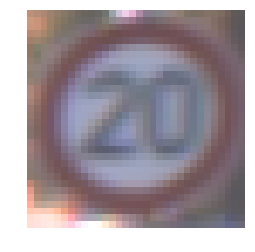

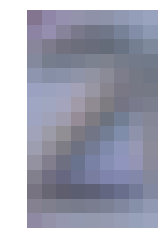

[ 1.1460507 -1.0914409]


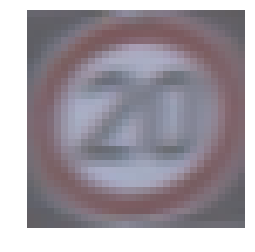

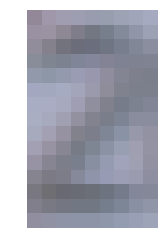

[ 0.82222193 -0.7004645 ]


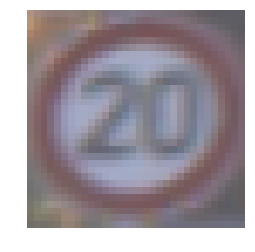

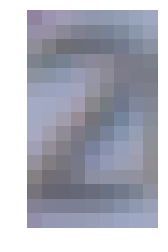

[ 0.92203    -0.86855876]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


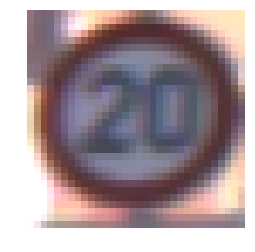

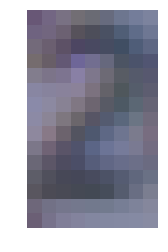

[ 2.8942792 -2.3722243]


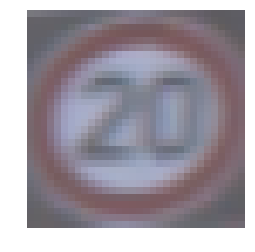

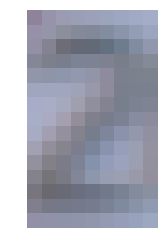

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.69797087 -0.81188107]


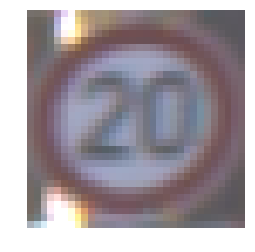

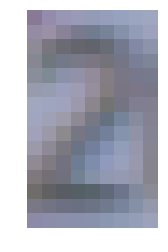

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.18243192  0.00495511]


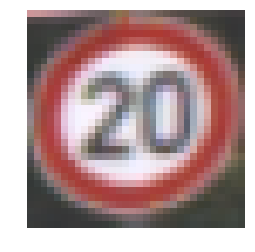

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


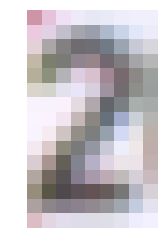

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.523607   1.8657633]


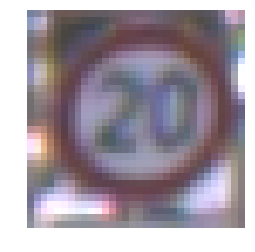

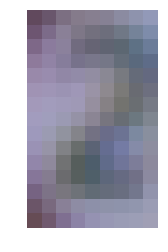

[ 2.7304847 -2.1502137]


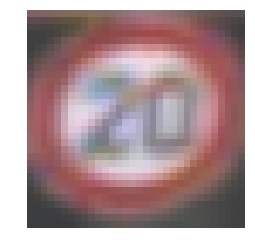

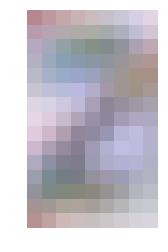

[ 1.4481025 -1.588954 ]


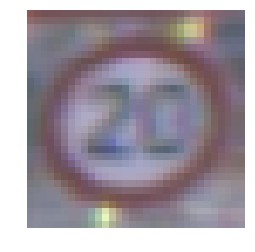

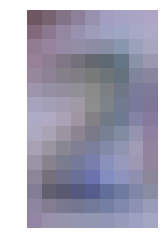

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.6423258 -0.7094046]


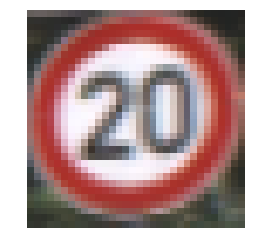

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


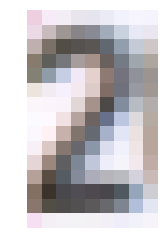

[-3.8010995  2.9277155]


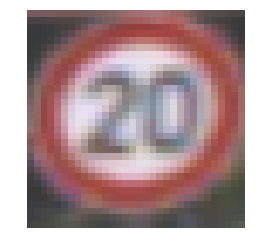

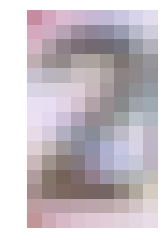

[ 0.1634678  -0.37408134]


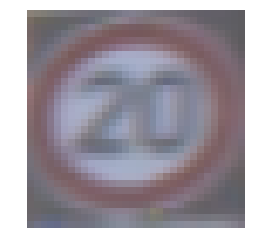

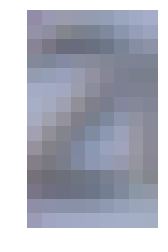

[ 0.4112297  -0.56815505]


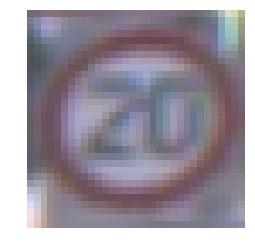

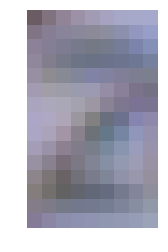

[ 0.1334721  -0.30891436]


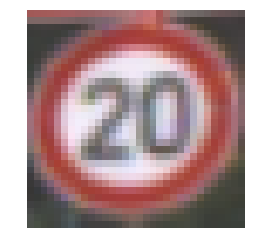

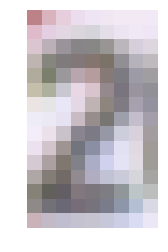

[-2.2248375  1.4768543]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


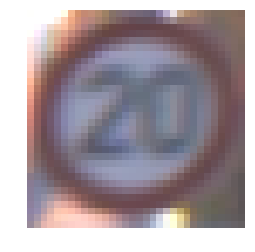

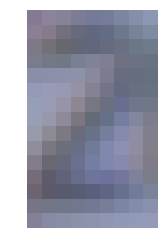

[ 1.0267386 -1.0210723]


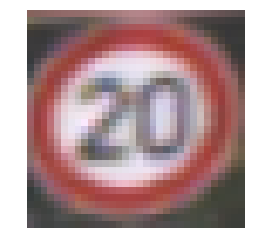

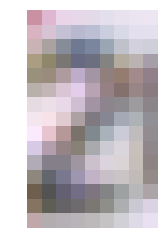

[-2.3219943  1.7447642]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


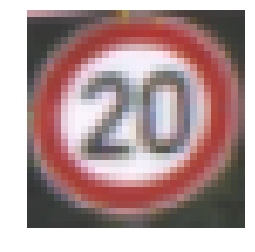

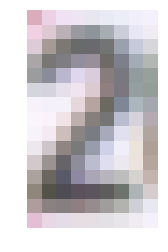

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.234129   1.6814032]


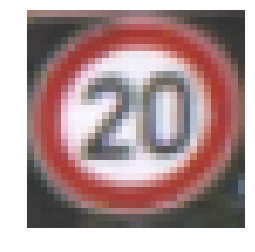

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


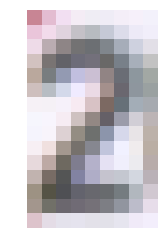

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.8252923  2.3408914]


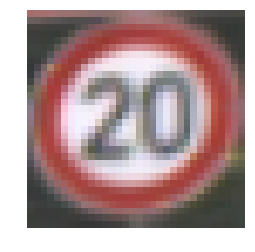

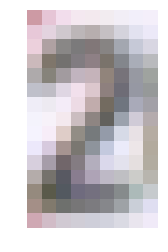

[-2.215758   1.8033059]


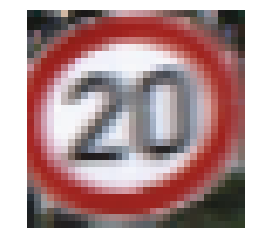

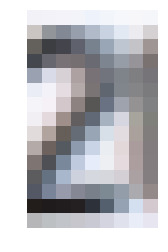

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.7644053  1.5216446]


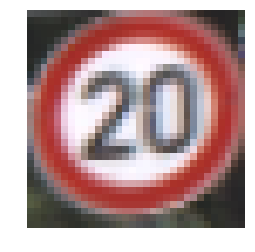

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


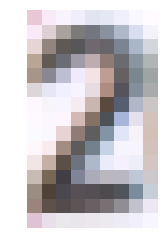

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.3876157  2.2154431]


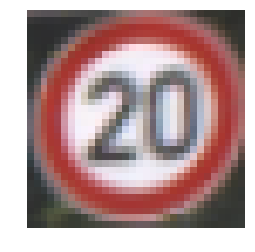

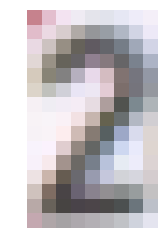

[-0.59546834  0.34625578]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


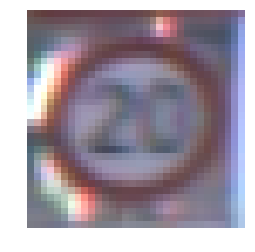

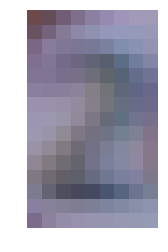

[ 0.1522527  -0.50090057]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


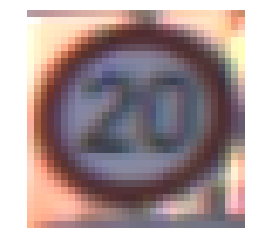

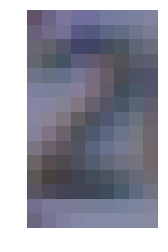

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.7552843 -2.5105953]


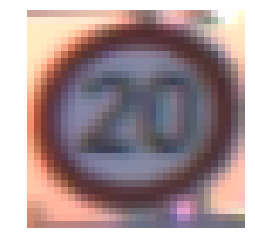

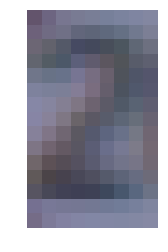

[ 2.4852717 -2.2714055]


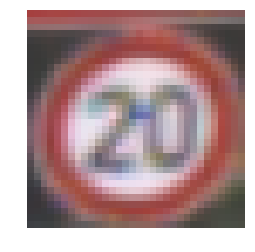

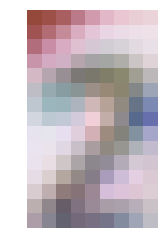

[ 2.1934817 -1.946604 ]


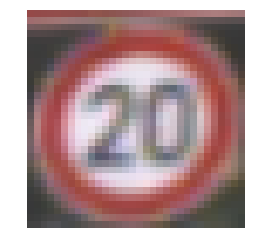

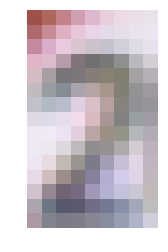

[ 0.08444455 -0.7971096 ]


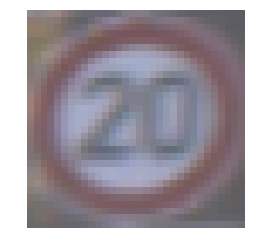

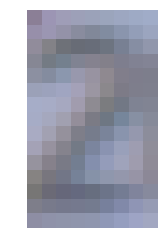

[ 0.8281234  -0.84234965]


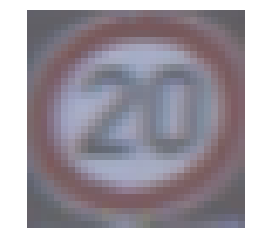

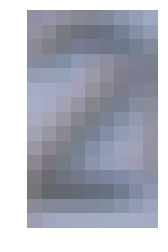

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.7656475 -0.6196582]


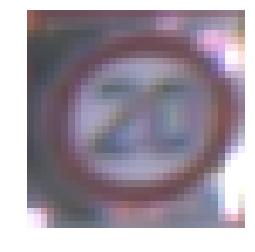

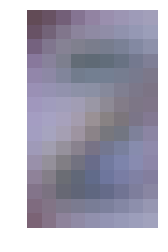

[ 2.2035482 -2.013373 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


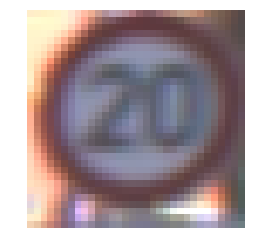

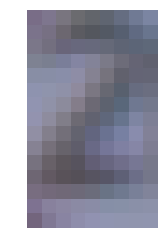

[ 2.264561  -1.7256367]


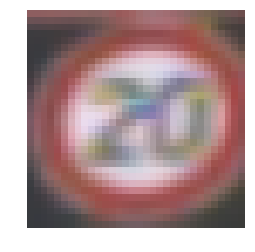

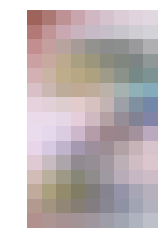

[ 3.6244688 -3.2271643]


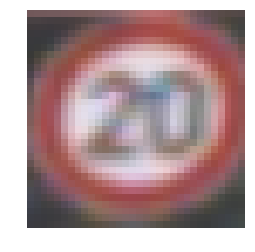

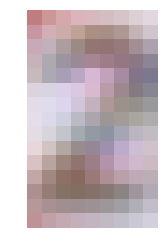

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.8287948 -1.58344  ]


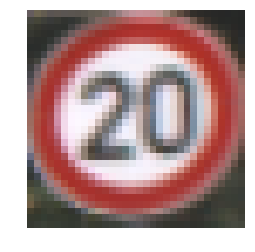

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


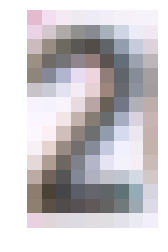

[-3.3915906  2.9981937]


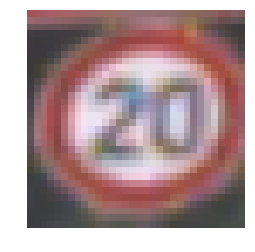

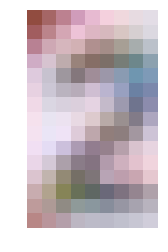

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.6096686 -1.4251764]


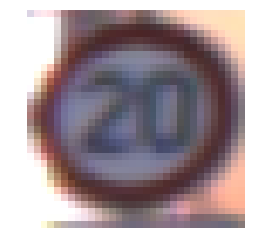

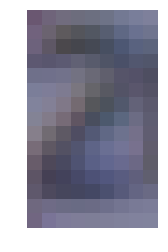

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.2187476 -3.6052516]


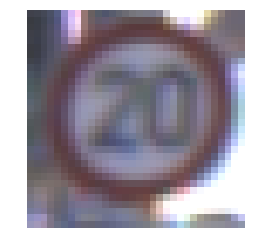

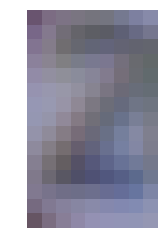

[ 3.4082077 -2.9721549]


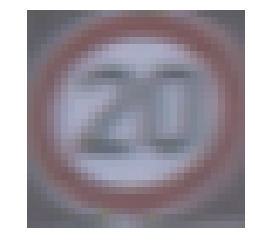

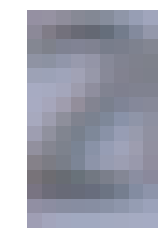

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.31259054 -0.19954428]


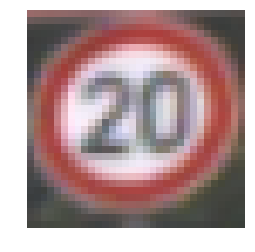

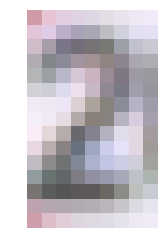

[-2.0893373  1.4216063]


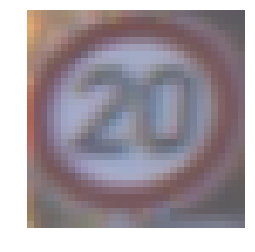

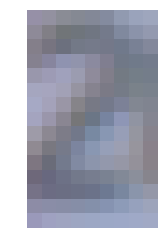

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.3187041  -0.49504802]


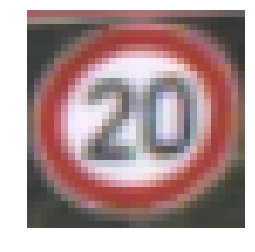

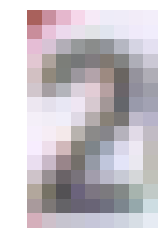

[-2.3422585  1.7066702]


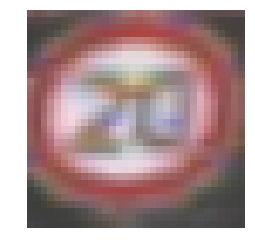

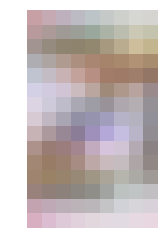

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.5711845 -1.2120838]


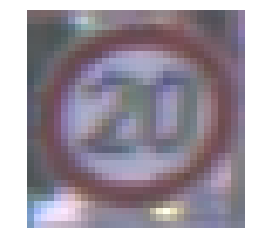

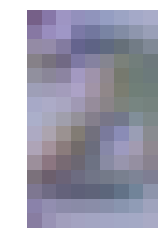

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.30409583 -0.528397  ]


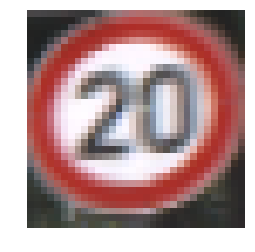

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


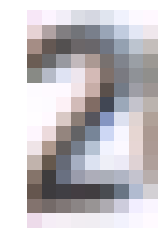

[-3.6319783  2.483928 ]


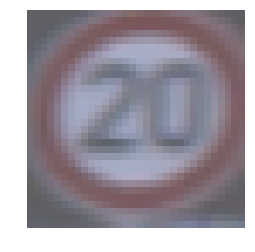

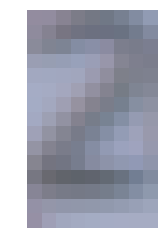

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.55494875 -0.07322871]


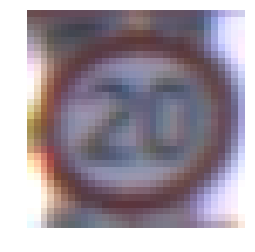

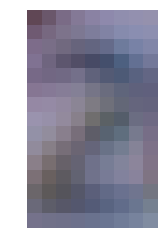

[ 1.2855923 -1.5107834]


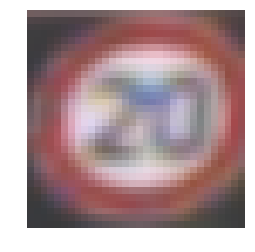

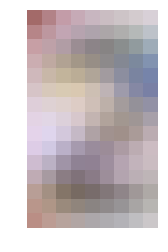

[ 3.5982137 -2.9714603]


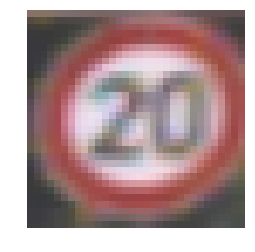

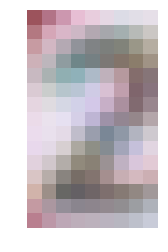

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.8051612 -2.4569983]


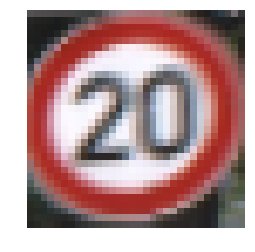

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


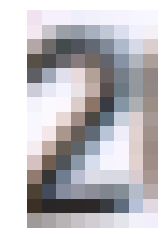

[-4.19695    2.7100148]


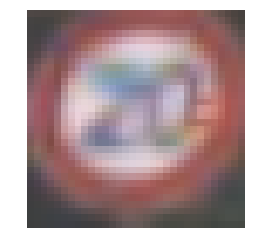

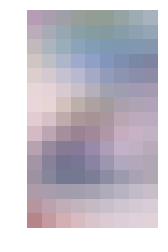

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.018643  -4.0232034]


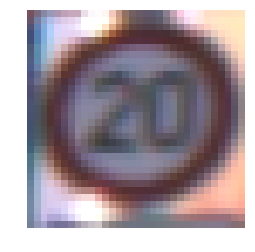

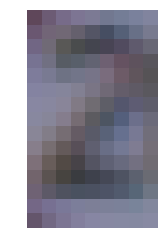

[ 3.287548  -2.9504352]


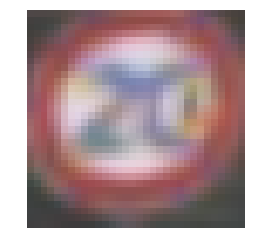

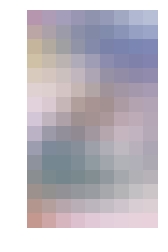

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.6193557 -3.6454282]


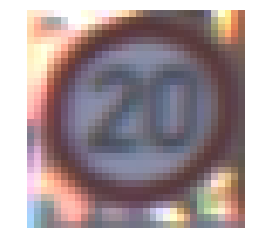

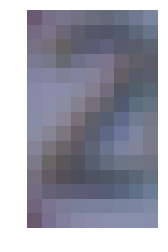

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.6652899 -3.004532 ]


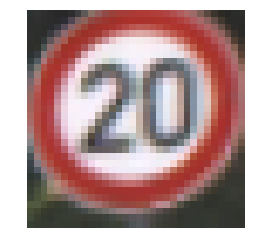

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


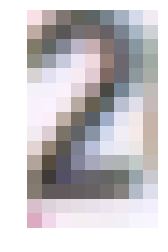

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.153166   1.4842534]


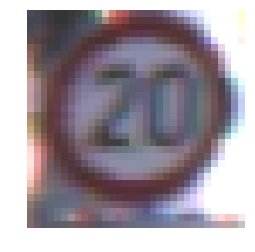

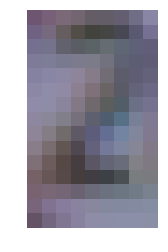

[ 1.5814235  -0.82909507]


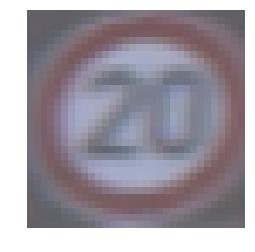

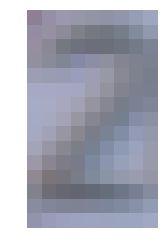

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.4605834 -1.3485734]


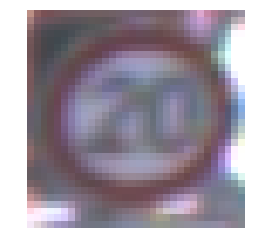

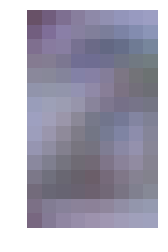

[ 1.4227711 -1.2459943]


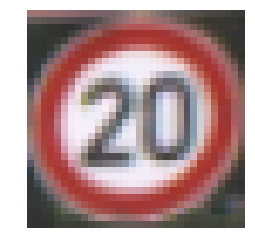

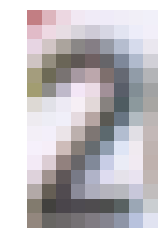

[-2.9699996  1.4177778]


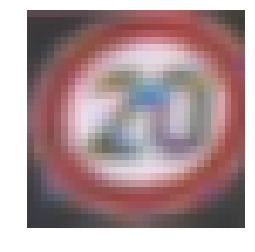

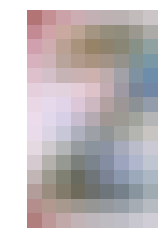

[ 3.11987   -2.6279066]


In [48]:
for x in X_test[np.where(y_test == 0)]:
#for x in X_train[np.where(y_train == 0)][:40]:
    
    x_stn = get_stn_output([x[np.newaxis, :], 0])[0][0]
    x_stn -= np.mean(x_stn)
#     x_p = get_patch(x_stn[np.newaxis, :], pos_2)[0]
    y = model_2.predict(x_stn[np.newaxis, :])[0]
    #if np.argmax(y) == 0:
    plt.imshow(x_stn*.5 + .5)
    plt.axis("off")
    plt.show()

    patch = get_patch(x_stn[np.newaxis, :], pos_2)[0]
    plt.imshow(patch*.5 + .5)
    plt.axis("off")
    plt.show()

    print(y)
    #print(1 / (1 + np.exp(-y)))

In [37]:
np.mean(X_train, axis=(1,2,3), keepdims=True).shape

(34799, 1, 1, 1)

In [13]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
from lib.utils import load_gtsrb
from parameters import *
from small_net import *
import logging

keras.layers.core.K.set_learning_phase(0)

# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

if K.image_dim_ordering() != 'tf':
    K.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
          "'th', temporarily setting to 'tf'")

# Create TF session and set as Keras backend session
sess = tf.Session()
K.set_session(sess)

set_log_level(logging.DEBUG)

# Load GTSRB dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Obtain Image Parameters
img_rows, img_cols, nchannels = X_train.shape[1:4]
nb_classes = y_train.shape[1]

# Choosing samples to attack
n_attack = 500
ind_1 = np.where(np.argmax(y_test, axis=1) == 1)
ind_14 = np.where(np.argmax(y_test, axis=1) == 14)
X_atk = np.zeros((n_attack, ) + X_test.shape[1:4])
X_atk[:n_attack//2] = X_test[ind_1][:n_attack//2]
X_atk[n_attack//2:] = X_test[ind_14][:n_attack//2]

y_target = np.zeros((n_attack, ))
y_target[:n_attack//2] = 14
y_target[n_attack//2:] = 1
y_target = to_categorical(y_target, nb_classes)
# print(y_target)

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, nchannels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

# Load and set up all models
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27)  # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

clf = conv_model_no_color_adjust()
clf.load_weights("./keras_weights/stn_v5.hdf5")

stn_weight = clf.layers[1].get_weights()
detect_3 = create_simple_cnn(pos_3)
detect_3.load_weights("./keras_weights/1_3.hdf5")
detect_0 = create_simple_cnn(pos_0)
detect_0.load_weights("./keras_weights/0.hdf5")
detect_S = create_simple_cnn(pos_S)
detect_S.load_weights("./keras_weights/14_S.hdf5")
detect_T = create_simple_cnn(pos_T)
detect_T.load_weights("./keras_weights/14_T.hdf5")
detect_O = create_simple_cnn(pos_O)
detect_O.load_weights("./keras_weights/14_O.hdf5")
detect_P = create_simple_cnn(pos_P)
detect_P.load_weights("./keras_weights/14_P.hdf5")

check_cnn = True
if check_cnn:
    y_test_cat = np.argmax(y_test, axis=1)
    print(eval_simple_cnn(detect_3, [1], X_test, y_test_cat))
    print(eval_simple_cnn(detect_0, [0, 1, 2, 3, 4, 5], X_test, y_test_cat))
    print(eval_simple_cnn(detect_S, [14], X_test, y_test_cat))
    print(eval_simple_cnn(detect_T, [14], X_test, y_test_cat))
    print(eval_simple_cnn(detect_O, [14], X_test, y_test_cat))
    print(eval_simple_cnn(detect_P, [14], X_test, y_test_cat))

wrap_clf = KerasModelWrapper(clf)
preds = clf(x)

eval_par = {'batch_size': 128}
acc = model_eval(sess, x, y, preds, X_test, y_test, args=eval_par)
print('Test accuracy on legitimate test examples: {0}'.format(acc))
report.clean_train_clean_eval = acc

# CarliniWagner attack
from lib.white_box_attack import CarliniWagnerL2_WB

ensemble = []
for i in range(nb_classes):
    nets = []
    if i == 1:
        nets.append(detect_3)
        nets.append(detect_0)
    elif i == 14:
        nets.append(detect_S)
        nets.append(detect_T)
        nets.append(detect_O)
        nets.append(detect_P)
    ensemble.append(nets)

wrap_ensemble = [[KerasModelWrapper(net) for net in nets] for nets in ensemble]

# Set up CW attack params
attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}

# ======================= MY CODE ======================= #
cw = CarliniWagnerL2_WB(wrap_clf, ensemble=wrap_ensemble, back='tf', sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

# Evaluate clean samples
pred_clf = clf.predict(X_atk)
pred_3 = detect_3.predict(X_atk)
pred_S = detect_S.predict(X_atk)
n_correct_clf = 0
n_correct_3 = 0
n_correct_S = 0
for i in range(n_attack):
    if i < n_attack//2:
        if np.argmax(pred_clf[i]) == 1:
            n_correct_clf += 1
            if np.argmax(pred_3[i]) == 1:
                n_correct_3 += 1
    else:
        if np.argmax(pred_clf[i]) == 14:
            n_correct_clf += 1
            if np.argmax(pred_S[i]) == 1:
                n_correct_S += 1
print("Correct classification only by clf: ", n_correct_clf)
print("Correct classification by clf & detect_3: ", n_correct_3)
print("Correct classification by clf & detect_S: ", n_correct_S)

# Evaluate adv
pred_clf = np.argmax(clf.predict(adv), axis=1)
pred_ensemble = []
for i in range(nb_classes):
    pred_nets = []
    for net in ensemble[i]:
        pred_nets.append(np.argmax(net.predict(adv), axis=1))
    pred_ensemble.append(pred_nets)

n_suc_clf = 0
n_suc_1 = 0
n_suc_14 = 0
for i in range(n_attack):
    if i < n_attack//2:
        if pred_clf[i] == 14:
            n_suc_clf += 1
            pred_ens_x = []
            for pred_net in pred_ensemble[14]:
                pred_ens_x.append(pred_net[i])
            if 0 not in pred_ens_x:
                n_suc_14 += 1
    else:
        if pred_clf[i] == 1:
            n_suc_clf += 1
            pred_ens_x = []
            for pred_net in pred_ensemble[1]:
                pred_ens_x.append(pred_net[i])
            if 0 not in pred_ens_x:
                n_suc_1 += 1

print("\n\n==========================================\n\n")
print("Successful attack only on clf: ", n_suc_clf)
print("Successful attack on clf & detect_3: ", n_suc_1)
print("Successful attack on clf & detect_S: ", n_suc_14)

(0.9937450514647664, 0.006045340050377834, 0.009722222222222222)
(0.9860649247822645, 0.014743589743589743, 0.011620795107033639)
(0.9989707046714172, 0.000970873786407767, 0.003703703703703704)
(0.9978622327790974, 0.002184466019417476, 0.0)
(0.998812351543943, 0.0012135922330097086, 0.0)
(0.9993665874901029, 0.0005663430420711974, 0.003703703703703704)


[INFO 2018-09-04 04:10:39,309 cleverhans] Constructing new graph for attack CarliniWagnerL2_WB


Test accuracy on legitimate test examples: 0.9922406967537609


[DEBUG 2018-09-04 04:10:45,560 cleverhans] Running CWL2 attack on instance 0 of 500
[DEBUG 2018-09-04 04:10:45,885 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-09-04 04:10:57,569 cleverhans]     Iteration 0 of 200: loss=1.95e+05 l2=0 f=-1.7
[DEBUG 2018-09-04 04:11:04,560 cleverhans]     Iteration 20 of 200: loss=2.16e+04 l2=41.6 f=-0.362
[DEBUG 2018-09-04 04:11:11,456 cleverhans]     Iteration 40 of 200: loss=1.36e+04 l2=27.1 f=-0.433
[DEBUG 2018-09-04 04:11:18,562 cleverhans]     Iteration 60 of 200: loss=8.96e+03 l2=17.8 f=-0.513
[DEBUG 2018-09-04 04:11:25,627 cleverhans]     Iteration 80 of 200: loss=6.91e+03 l2=13.8 f=-0.574
[DEBUG 2018-09-04 04:11:32,534 cleverhans]     Iteration 100 of 200: loss=6.33e+03 l2=12.2 f=-0.622
[DEBUG 2018-09-04 04:11:39,396 cleverhans]     Iteration 120 of 200: loss=7.21e+03 l2=14 f=-0.645
[DEBUG 2018-09-04 04:11:39,397 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-09-04 04:11:39,403 cleverhans]   Successfully generated adversa

Correct classification only by clf:  500
Correct classification by clf & detect_3:  249
Correct classification by clf & detect_S:  249




Successful attack only on clf:  500
Successful attack on clf & detect_3:  250
Successful attack on clf & detect_S:  250


In [18]:
np.mean(np.linalg.norm((adv - X_atk).reshape(500, -1), axis=1))

2.1468853823103764

---

## Check color and shape classification

https://matplotlib.org/_modules/matplotlib/colors.html#rgb_to_hsv

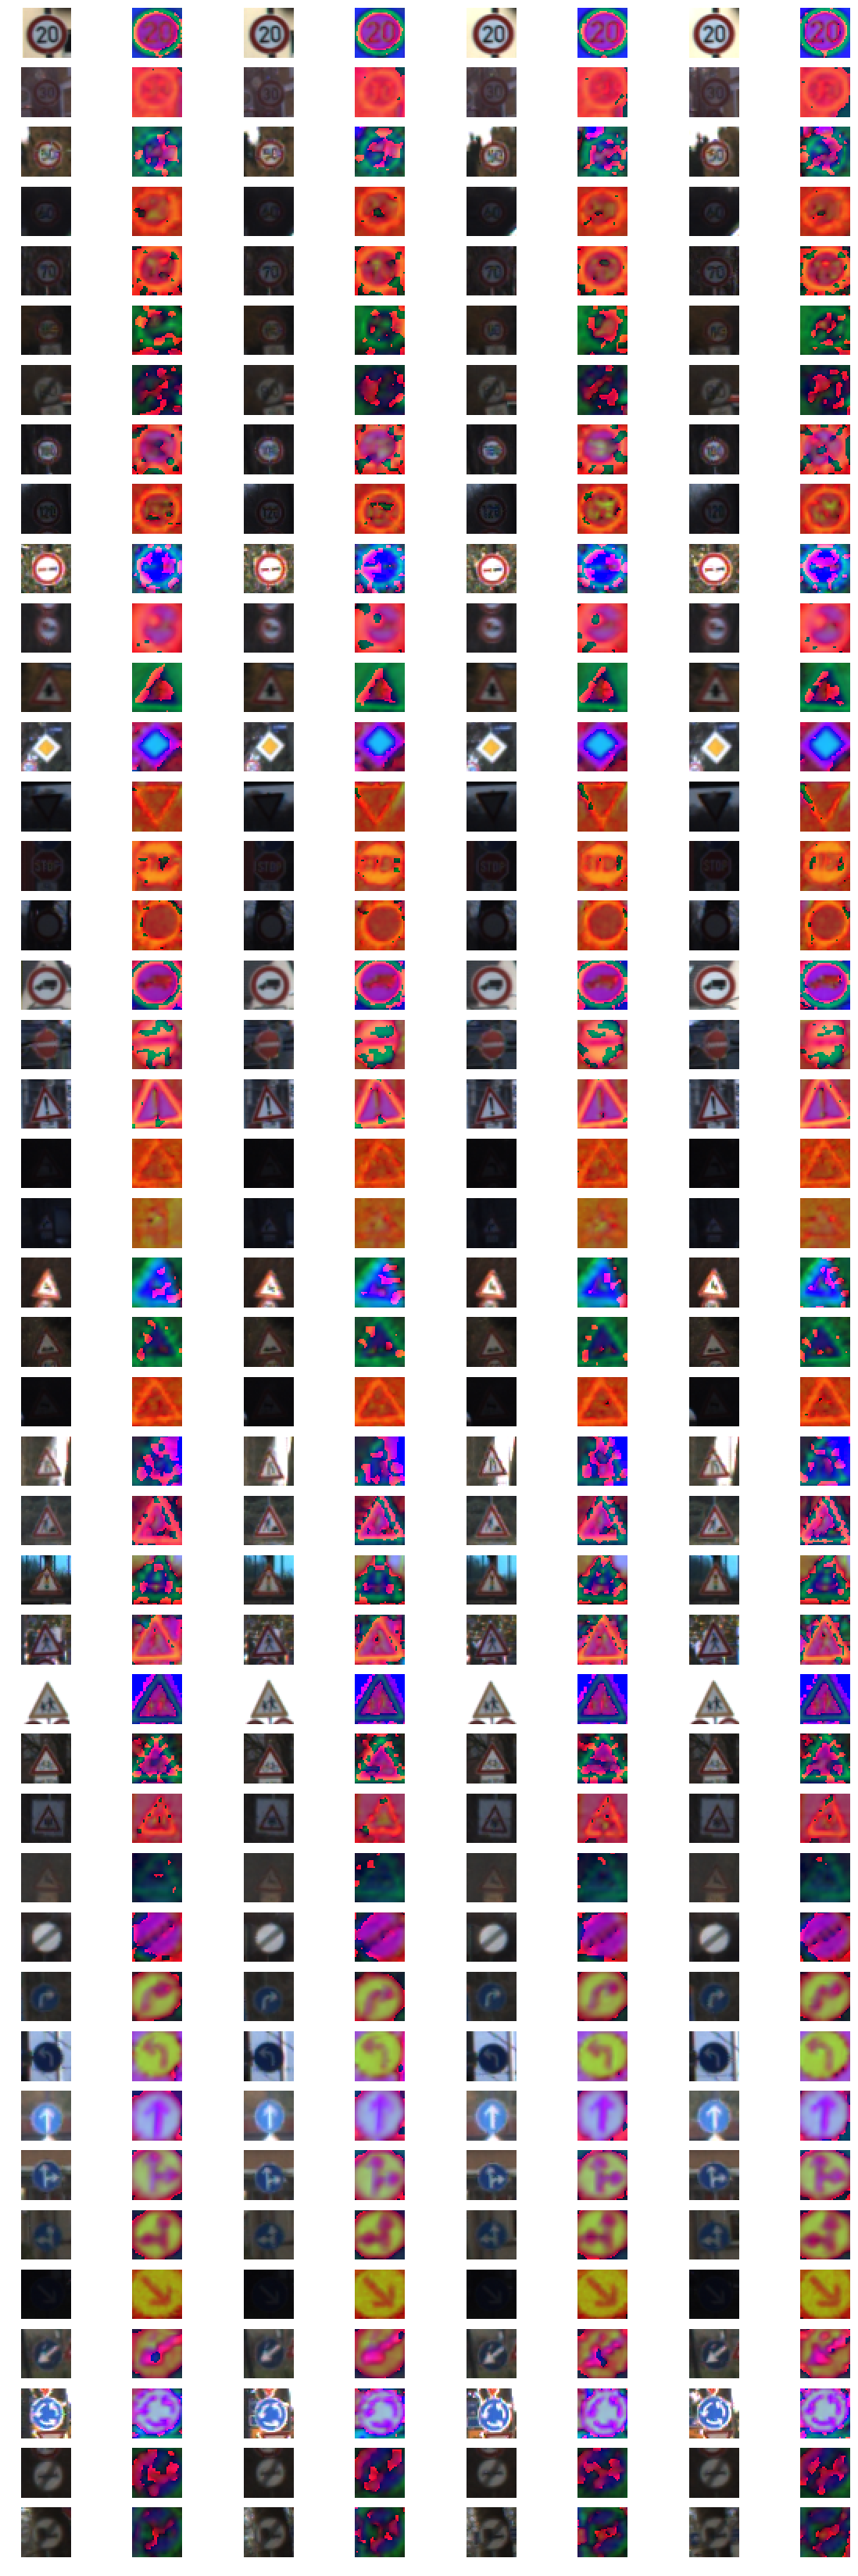

In [8]:
from matplotlib.colors import rgb_to_hsv
X = X_train
y = y_train

f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
for i in range(NUM_LABELS):
    
    ind = np.where(y == i)
    for j in range(4):

        x = X[ind][j]
        ax[i, j*2].imshow(x)
        ax[i, j*2].axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        x = x/2 + 0.5
        x_hsv = rgb_to_hsv(x)
        
        ax[i, j*2 + 1].imshow(x)
        ax[i, j*2 + 1].axis("off")

---

## Try Template Matching with STN

In [159]:
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

# ======================== Pick one class for testing ======================== #
# Load template
label = 14

TEM_DIR = "./templates/"
template = imread("{}{}.png".format(TEM_DIR, label))
template = template / 255.
template = resize(template, (32, 32), order=0)

# Select traing samples
X_train = X_train[y_train == label]
X_test = X_test[y_test == label]
X_val = X_val[y_val == label]

# X_train = np.clip(X_train - np.mean(X_train, axis=0), 0, 1)
# X_test = np.clip(X_test - np.mean(X_test, axis=0), 0, 1)
# X_val = np.clip(X_val - np.mean(X_val, axis=0), 0, 1)

print("Number of training examples =", X_train.shape[0])
print("Number of validating examples =", X_val.shape[0])
print("Number of testing examples =", X_test.shape[0])
print("Image data shape =", X_train[0].shape)
print("Number of classes =", NUM_LABELS)

Number of training examples = 690
Number of validating examples = 90
Number of testing examples = 270
Image data shape = (32, 32, 3)
Number of classes = 43


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(-0.5, 31.5, 31.5, -0.5)

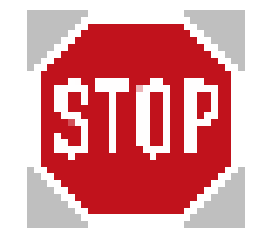

In [160]:
x = np.copy(template)
x[np.where(x[:, :, 3] == 0.)] = 0.5
plt.imshow(x)
plt.axis('off')

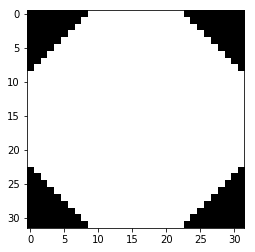

In [200]:
# Mask
def get_mask(img):
    """Get mask from 4-channel (RGBa) image"""
    mask = np.ones(img.shape[:2] + (3,))
    mask[img[:, :, 3] == 0] = 0
    return mask.astype(np.float32)

MASK = get_mask(template)
plt.imshow(MASK)
imwrite('template_{}.png'.format(label), MASK)

# Custom loss
def custom_loss(y_true, y_pred):
    mask = tf.constant(MASK)
    
    # diff = tf.square(y_true - y_pred)
    diff = tf.abs(y_true - y_pred)
    
    masked_diff = tf.multiply(MASK, diff)
    loss = tf.reduce_sum(masked_diff)
    return loss

In [187]:
from keras.layers import Activation

def locnet():
    n_dense = 128
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((n_dense, 6), dtype='float32')
    weights = [W, b.flatten()]
    locnet = Sequential()

    locnet.add(Conv2D(32, (5, 5), padding='same', input_shape=(32, 32, 3)))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (5, 5), padding='same'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(128, (5, 5), padding='same'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))

    locnet.add(Flatten())
    locnet.add(Dense(256))
    locnet.add(Activation('elu'))
    locnet.add(Dense(n_dense))
    locnet.add(Activation('elu'))
    locnet.add(Dense(6, weights=weights))

    return locnet


def template_match_nn():

    model = Sequential()
#     model.add(Lambda(
#         lambda x: x*2 - 1.,
#         input_shape=(32, 32, 3),
#         output_shape=(32, 32, 3)))
    model.add(SpatialTransformer(localization_net=locnet(),
                                 input_shape=(32, 32, 3),
                                 output_size=(32, 32, 3)))
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss=custom_loss, optimizer=adam)

    return model

In [191]:
batch_size = 32
epochs = 100
model = template_match_nn()
save_path = "./keras_weights/tm_v0.hdf5"

checkpointer = ModelCheckpoint(
    filepath=save_path, verbose=1, save_best_only=True,
    save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
                          verbose=0, mode='auto', baseline=None)

y_train = np.tile(template[:, :, :3], (len(X_train), 1, 1, 1))
y_test = np.tile(template[:, :, :3], (len(X_test), 1, 1, 1))
y_val = np.tile(template[:, :, :3], (len(X_val), 1, 1, 1))

aug_range = 0.1
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=aug_range,
    height_shift_range=aug_range,
    zoom_range=aug_range,
    channel_shift_range=aug_range)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs,
                    verbose=1, shuffle=True,
                    callbacks=[checkpointer, earlystop],
                    validation_data=(X_val, y_val))
# model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(X_val, y_val),
#           shuffle=True,
#           callbacks=[checkpointer, earlystop])

Epoch 1/100
22/21 [==============================] - 3s 121ms/step - loss: 29350.3977 - val_loss: 26145.2683

Epoch 00001: val_loss improved from inf to 26145.26827, saving model to ./keras_weights/tm_v0.hdf5
Epoch 2/100
22/21 [==============================] - 0s 11ms/step - loss: 28313.1735 - val_loss: 25662.7543

Epoch 00002: val_loss improved from 26145.26827 to 25662.75434, saving model to ./keras_weights/tm_v0.hdf5
Epoch 3/100
22/21 [==============================] - 0s 21ms/step - loss: 28329.6672 - val_loss: 25963.0102

Epoch 00003: val_loss did not improve from 25662.75434
Epoch 4/100
22/21 [==============================] - 0s 20ms/step - loss: 27790.8663 - val_loss: 26410.5848

Epoch 00004: val_loss did not improve from 25662.75434
Epoch 5/100
22/21 [==============================] - 0s 18ms/step - loss: 27330.5169 - val_loss: 15479.5309

Epoch 00005: val_loss improved from 25662.75434 to 15479.53086, saving model to ./keras_weights/tm_v0.hdf5
Epoch 6/100
22/21 [============

In [192]:
# get_st_params = K.function([model.layers[1].locnet.input, K.learning_phase()],
#                            [model.layers[1].locnet.output])
get_st_params = K.function([model.layers[0].locnet.input, K.learning_phase()],
                           [model.layers[0].locnet.output])

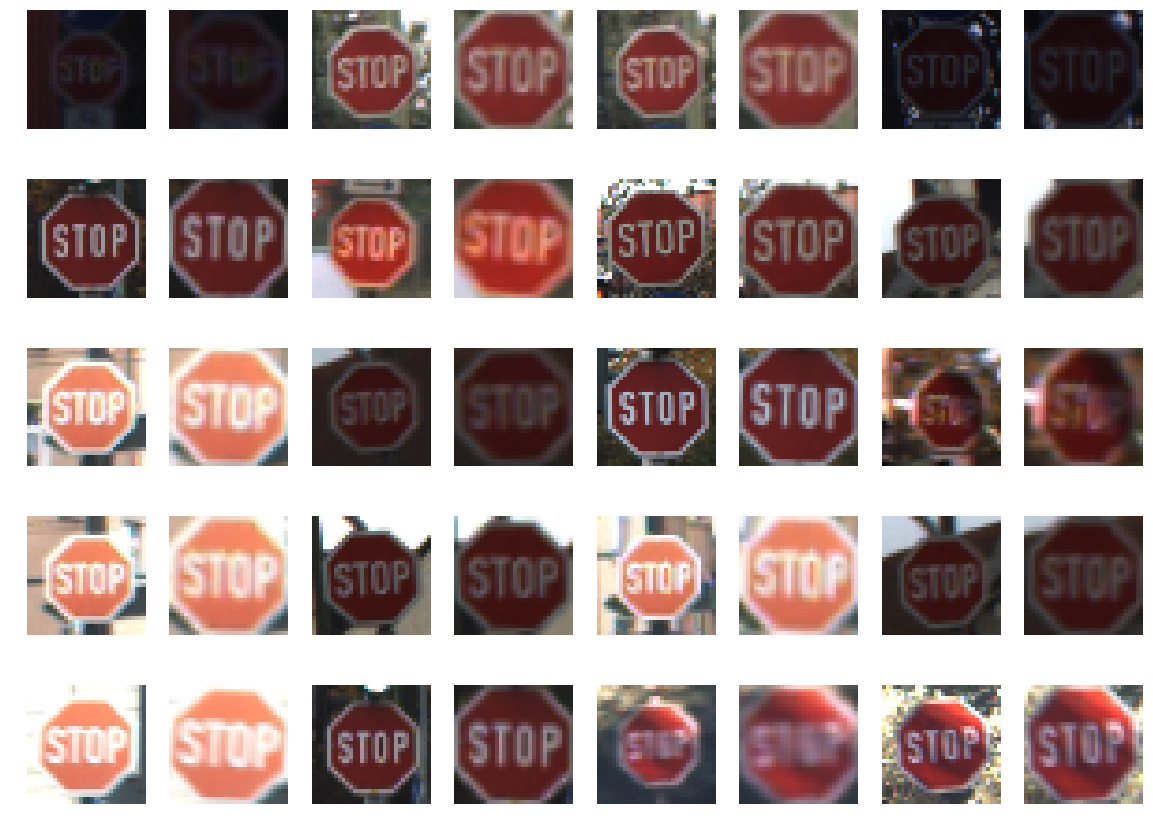

In [195]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 15))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    param = get_st_params([x[np.newaxis, :], 0])[0]
    stn_output = model.predict(x[np.newaxis, :])[0]
    ax[ii, jj + 1].imshow(stn_output)
    ax[ii, jj + 1].axis("off")
#     ax[ii, jj + 1].set_title("{}\n{}\n{}\n{}\n{}\n{}".format(*param[0]))

In [154]:
diff = np.abs(model.predict(X_train) - y_train) * MASK
loss = np.sum(diff.reshape(-1, 32*32*3), axis=1)
print("Train error - mean: ", np.mean(loss))
print("Train error - std: ", np.std(loss))
print("\n")

diff = np.abs(model.predict(X_test) - y_test) * MASK
loss = np.sum(diff.reshape(-1, 32*32*3), axis=1)
print("Test error - mean: ", np.mean(loss))
print("Test error - std: ", np.std(loss))
print("\n")

diff = np.abs(model.predict(X_val) - y_val) * MASK
loss = np.sum(diff.reshape(-1, 32*32*3), axis=1)
print("Val error - mean: ", np.mean(loss))
print("Val error - std: ", np.std(loss))

Train error - mean:  769.1475324859745
Train error - std:  158.99558875330803


Test error - mean:  871.4994830485656
Test error - std:  135.8276303011376


Val error - mean:  792.5945217182597
Val error - std:  145.82964671337916


--- 
# Transformation

In [5]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [6]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

Mean of RGB image


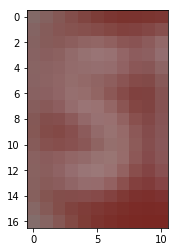

Sample closest to the mean


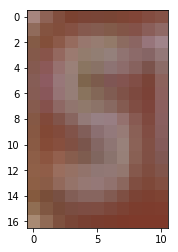

L2 dist from mean: 1.0824


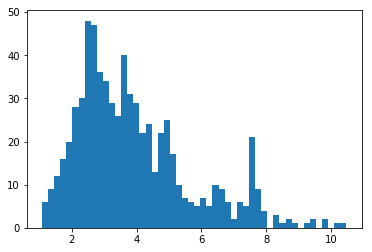

In [7]:
# Try transformaing 'S'
import matplotlib

X_S = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)

print("Mean of RGB image")
mean = np.mean(S, axis=0)
plt.imshow(mean)
plt.show()
    
# Sample that's closest to the mean
dist = np.sqrt(np.sum(np.square(S - mean).reshape(S.shape[0], -1), axis=1))
ind_center = np.argmin(dist)
print("Sample closest to the mean")
x_mean = S[ind_center]
plt.imshow(x_mean)
plt.show()
print("L2 dist from mean: {:.4f}".format(dist[ind_center]))
plt.hist(dist, bins=50)
plt.show()

In [25]:
n = 100
X_stop = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
O = get_patch(X_stn, pos_O)

In [15]:
from lib.transformer_tf_v2 import Transformer

sess = tf.get_default_session()
transformer = Transformer(S.shape[1:], sess=sess, batch_size=n, 
                          learning_rate=5e-4, hsv=False)

ValueError: Dimension 0 in both shapes must be equal, but are 1 and 100. Shapes are [1] and [100]. for 'Transformer_1/_transform/MatMul' (op: 'BatchMatMul') with input shapes: [1,2,3], [100,3,187].

In [16]:
# Match with mean
templates = np.repeat(x_mean[np.newaxis], n, axis=0)
s = transformer.transform(S[:n], templates, n_steps=500)
s = np.clip(s, 0, 1)

o = transformer.transform(O[:n], templates, n_steps=500)
o = np.clip(o, 0, 1)

ValueError: Cannot feed value of shape (100, 17, 11, 3) for Tensor 'transformer_templates:0', which has shape '(1, 17, 11, 3)'

In [28]:
from lib.transformer_tf_v2 import Transformer

sess = tf.get_default_session()
transformer = Transformer(S.shape[1:], sess=sess, batch_size=1, 
                          learning_rate=1e-3, hsv=False)
templates = np.repeat(x_mean[np.newaxis], 1, axis=0)

s = np.zeros_like(S[:n])
for i in range(n):
    s[i] = transformer.transform(S[i][np.newaxis], templates, n_steps=200)
s = np.clip(s, 0, 1)

o = np.zeros_like(O[:n])
for i in range(n):
    o[i] = transformer.transform(O[i][np.newaxis], templates, n_steps=200)
o = np.clip(o, 0, 1)

step: 0 - loss: 31.8254
step: 10 - loss: 36.2186
step: 20 - loss: 35.8433
step: 30 - loss: 35.6032
step: 40 - loss: 35.1573
step: 50 - loss: 34.7254
step: 60 - loss: 33.5033
step: 70 - loss: 31.9961
step: 80 - loss: 31.5423
step: 90 - loss: 30.3942
step: 100 - loss: 28.4612
step: 110 - loss: 27.5768
step: 120 - loss: 27.0285
step: 130 - loss: 26.9247
step: 140 - loss: 26.4646
step: 150 - loss: 25.9214
step: 160 - loss: 25.4541
step: 170 - loss: 25.4018
step: 180 - loss: 24.8432
step: 190 - loss: 24.4603
step: 0 - loss: 23.7267
step: 10 - loss: 25.4241
step: 20 - loss: 25.0613
step: 30 - loss: 25.5009
step: 40 - loss: 24.1134
step: 50 - loss: 22.3490
step: 60 - loss: 21.6848
step: 70 - loss: 21.1578
step: 80 - loss: 20.9926
step: 90 - loss: 19.9686
step: 100 - loss: 19.2610
step: 110 - loss: 18.4311
step: 120 - loss: 18.0303
step: 130 - loss: 17.6385
step: 140 - loss: 17.2530
step: 150 - loss: 16.8622
step: 160 - loss: 16.4747
step: 170 - loss: 16.0950
step: 180 - loss: 16.0131
step: 19

step: 70 - loss: 66.0295
step: 80 - loss: 65.5877
step: 90 - loss: 64.5828
step: 100 - loss: 63.7388
step: 110 - loss: 63.4177
step: 120 - loss: 62.9449
step: 130 - loss: 62.8227
step: 140 - loss: 62.2826
step: 150 - loss: 61.8868
step: 160 - loss: 61.3946
step: 170 - loss: 61.2620
step: 180 - loss: 61.1357
step: 190 - loss: 60.8279
step: 0 - loss: 83.2020
step: 10 - loss: 83.1737
step: 20 - loss: 82.6662
step: 30 - loss: 83.0274
step: 40 - loss: 81.7323
step: 50 - loss: 81.2043
step: 60 - loss: 80.4414
step: 70 - loss: 80.0308
step: 80 - loss: 79.2875
step: 90 - loss: 78.0636
step: 100 - loss: 77.1889
step: 110 - loss: 76.3591
step: 120 - loss: 75.1524
step: 130 - loss: 74.1483
step: 140 - loss: 73.1134
step: 150 - loss: 73.0647
step: 160 - loss: 72.6088
step: 170 - loss: 73.0322
step: 180 - loss: 73.0876
step: 190 - loss: 72.7581
step: 0 - loss: 20.2016
step: 10 - loss: 25.8746
step: 20 - loss: 25.2275
step: 30 - loss: 24.6659
step: 40 - loss: 24.1146
step: 50 - loss: 23.4711
step: 6

step: 110 - loss: 71.7767
step: 120 - loss: 71.5052
step: 130 - loss: 71.4335
step: 140 - loss: 71.3250
step: 150 - loss: 71.2382
step: 160 - loss: 71.1664
step: 170 - loss: 71.1003
step: 180 - loss: 71.0314
step: 190 - loss: 70.9440
step: 0 - loss: 18.9557
step: 10 - loss: 28.6364
step: 20 - loss: 27.4901
step: 30 - loss: 27.4393
step: 40 - loss: 28.0936
step: 50 - loss: 27.9973
step: 60 - loss: 28.3144
step: 70 - loss: 28.2707
step: 80 - loss: 29.2164
step: 90 - loss: 30.3352
step: 100 - loss: 29.6467
step: 110 - loss: 30.3858
step: 120 - loss: 30.9916
step: 130 - loss: 31.4744
step: 140 - loss: 32.2480
step: 150 - loss: 32.2788
step: 160 - loss: 32.7883
step: 170 - loss: 32.7542
step: 180 - loss: 32.3962
step: 190 - loss: 32.4539
step: 0 - loss: 22.9361
step: 10 - loss: 24.7303
step: 20 - loss: 24.3392
step: 30 - loss: 24.0769
step: 40 - loss: 23.6072
step: 50 - loss: 23.1790
step: 60 - loss: 22.7239
step: 70 - loss: 22.1556
step: 80 - loss: 21.2264
step: 90 - loss: 21.1867
step: 10

step: 10 - loss: 28.3929
step: 20 - loss: 28.1756
step: 30 - loss: 29.1106
step: 40 - loss: 30.0576
step: 50 - loss: 30.2990
step: 60 - loss: 30.0756
step: 70 - loss: 30.8310
step: 80 - loss: 32.0119
step: 90 - loss: 33.2728
step: 100 - loss: 33.5439
step: 110 - loss: 32.4618
step: 120 - loss: 30.6577
step: 130 - loss: 29.5790
step: 140 - loss: 30.2884
step: 150 - loss: 29.6319
step: 160 - loss: 28.6653
step: 170 - loss: 27.1876
step: 180 - loss: 25.9484
step: 190 - loss: 24.5282
step: 0 - loss: 68.5444
step: 10 - loss: 71.3557
step: 20 - loss: 73.2864
step: 30 - loss: 73.0577
step: 40 - loss: 72.2617
step: 50 - loss: 70.8342
step: 60 - loss: 72.2375
step: 70 - loss: 72.2679
step: 80 - loss: 72.0506
step: 90 - loss: 72.2432
step: 100 - loss: 72.2005
step: 110 - loss: 71.6830
step: 120 - loss: 71.5120
step: 130 - loss: 71.7270
step: 140 - loss: 72.8008
step: 150 - loss: 73.7400
step: 160 - loss: 74.6013
step: 170 - loss: 74.7832
step: 180 - loss: 75.3513
step: 190 - loss: 74.9621
step: 

step: 60 - loss: 21.5890
step: 70 - loss: 21.4554
step: 80 - loss: 20.9938
step: 90 - loss: 20.0448
step: 100 - loss: 19.4873
step: 110 - loss: 18.8899
step: 120 - loss: 17.6810
step: 130 - loss: 17.0484
step: 140 - loss: 16.9629
step: 150 - loss: 16.3344
step: 160 - loss: 15.8779
step: 170 - loss: 14.4959
step: 180 - loss: 14.4635
step: 190 - loss: 14.0945
step: 0 - loss: 19.0453
step: 10 - loss: 28.8642
step: 20 - loss: 28.6830
step: 30 - loss: 28.5241
step: 40 - loss: 28.1134
step: 50 - loss: 27.0180
step: 60 - loss: 26.4337
step: 70 - loss: 25.6086
step: 80 - loss: 25.4751
step: 90 - loss: 27.6600
step: 100 - loss: 28.6886
step: 110 - loss: 29.9888
step: 120 - loss: 30.8792
step: 130 - loss: 31.3584
step: 140 - loss: 31.5471
step: 150 - loss: 32.3044
step: 160 - loss: 31.7011
step: 170 - loss: 31.3235
step: 180 - loss: 31.2859
step: 190 - loss: 31.2505
step: 0 - loss: 23.7871
step: 10 - loss: 28.1941
step: 20 - loss: 26.5329
step: 30 - loss: 25.9190
step: 40 - loss: 24.4742
step: 5

step: 160 - loss: 14.6704
step: 170 - loss: 14.1962
step: 180 - loss: 13.4885
step: 190 - loss: 13.0334
step: 0 - loss: 38.6086
step: 10 - loss: 43.7167
step: 20 - loss: 43.5354
step: 30 - loss: 43.1735
step: 40 - loss: 42.6137
step: 50 - loss: 41.6688
step: 60 - loss: 40.5692
step: 70 - loss: 39.9985
step: 80 - loss: 40.4851
step: 90 - loss: 40.2791
step: 100 - loss: 39.6082
step: 110 - loss: 38.7431
step: 120 - loss: 38.5066
step: 130 - loss: 38.0234
step: 140 - loss: 37.6629
step: 150 - loss: 37.8521
step: 160 - loss: 37.4135
step: 170 - loss: 37.4235
step: 180 - loss: 38.0500
step: 190 - loss: 38.2496
step: 0 - loss: 33.2677
step: 10 - loss: 33.2523
step: 20 - loss: 33.5051
step: 30 - loss: 33.6148
step: 40 - loss: 33.2652
step: 50 - loss: 32.5600
step: 60 - loss: 31.7002
step: 70 - loss: 30.8876
step: 80 - loss: 30.3847
step: 90 - loss: 29.8868
step: 100 - loss: 29.3496
step: 110 - loss: 28.4151
step: 120 - loss: 28.2442
step: 130 - loss: 27.1203
step: 140 - loss: 26.9871
step: 15

step: 40 - loss: 37.0017
step: 50 - loss: 38.0346
step: 60 - loss: 37.4321
step: 70 - loss: 36.1971
step: 80 - loss: 35.9587
step: 90 - loss: 36.1323
step: 100 - loss: 35.6543
step: 110 - loss: 34.8248
step: 120 - loss: 34.3137
step: 130 - loss: 34.2553
step: 140 - loss: 33.8723
step: 150 - loss: 34.7794
step: 160 - loss: 34.2179
step: 170 - loss: 34.1620
step: 180 - loss: 33.8600
step: 190 - loss: 33.2354
step: 0 - loss: 35.4547
step: 10 - loss: 39.3350
step: 20 - loss: 39.2970
step: 30 - loss: 39.0608
step: 40 - loss: 38.6200
step: 50 - loss: 38.5060
step: 60 - loss: 37.4011
step: 70 - loss: 36.5318
step: 80 - loss: 34.9062
step: 90 - loss: 33.8549
step: 100 - loss: 32.5444
step: 110 - loss: 31.7707
step: 120 - loss: 30.1529
step: 130 - loss: 29.5840
step: 140 - loss: 28.4297
step: 150 - loss: 27.9624
step: 160 - loss: 27.5056
step: 170 - loss: 27.0293
step: 180 - loss: 26.4775
step: 190 - loss: 25.7429
step: 0 - loss: 32.3191
step: 10 - loss: 31.9464
step: 20 - loss: 32.1121
step: 3

step: 70 - loss: 29.7334
step: 80 - loss: 28.1703
step: 90 - loss: 28.0154
step: 100 - loss: 27.8688
step: 110 - loss: 23.6166
step: 120 - loss: 23.9349
step: 130 - loss: 24.7688
step: 140 - loss: 24.7296
step: 150 - loss: 25.3118
step: 160 - loss: 29.0177
step: 170 - loss: 27.1749
step: 180 - loss: 26.5755
step: 190 - loss: 26.4526
step: 0 - loss: 25.1111
step: 10 - loss: 28.7800
step: 20 - loss: 28.6660
step: 30 - loss: 27.5647
step: 40 - loss: 26.8901
step: 50 - loss: 26.9060
step: 60 - loss: 26.4583
step: 70 - loss: 26.2880
step: 80 - loss: 26.9174
step: 90 - loss: 26.3167
step: 100 - loss: 25.5719
step: 110 - loss: 24.4057
step: 120 - loss: 23.9774
step: 130 - loss: 23.2340
step: 140 - loss: 22.4570
step: 150 - loss: 21.5345
step: 160 - loss: 21.2287
step: 170 - loss: 21.0625
step: 180 - loss: 20.5961
step: 190 - loss: 20.0527
step: 0 - loss: 66.3444
step: 10 - loss: 66.2880
step: 20 - loss: 66.5704
step: 30 - loss: 66.7254
step: 40 - loss: 66.5585
step: 50 - loss: 66.4001
step: 6

step: 160 - loss: 28.9099
step: 170 - loss: 28.9241
step: 180 - loss: 28.6440
step: 190 - loss: 28.1202
step: 0 - loss: 33.2654
step: 10 - loss: 36.3344
step: 20 - loss: 36.5843
step: 30 - loss: 36.5535
step: 40 - loss: 36.1661
step: 50 - loss: 35.7547
step: 60 - loss: 35.6932
step: 70 - loss: 34.4542
step: 80 - loss: 33.1316
step: 90 - loss: 31.1561
step: 100 - loss: 29.4375
step: 110 - loss: 28.0408
step: 120 - loss: 26.3955
step: 130 - loss: 25.1294
step: 140 - loss: 23.9913
step: 150 - loss: 22.9596
step: 160 - loss: 22.6925
step: 170 - loss: 22.0866
step: 180 - loss: 21.0665
step: 190 - loss: 21.3902
step: 0 - loss: 67.3103
step: 10 - loss: 67.3004
step: 20 - loss: 67.5569
step: 30 - loss: 68.1869
step: 40 - loss: 68.1942
step: 50 - loss: 68.0657
step: 60 - loss: 68.1941
step: 70 - loss: 68.3105
step: 80 - loss: 68.2721
step: 90 - loss: 68.3356
step: 100 - loss: 68.2734
step: 110 - loss: 68.1306
step: 120 - loss: 67.8322
step: 130 - loss: 67.9769
step: 140 - loss: 67.6417
step: 15

step: 20 - loss: 65.8140
step: 30 - loss: 66.2021
step: 40 - loss: 66.2728
step: 50 - loss: 66.2391
step: 60 - loss: 66.3217
step: 70 - loss: 66.2589
step: 80 - loss: 66.0875
step: 90 - loss: 65.7844
step: 100 - loss: 65.4053
step: 110 - loss: 65.1209
step: 120 - loss: 64.7680
step: 130 - loss: 64.2947
step: 140 - loss: 64.0921
step: 150 - loss: 63.7890
step: 160 - loss: 63.7550
step: 170 - loss: 63.8089
step: 180 - loss: 63.6961
step: 190 - loss: 63.5589
step: 0 - loss: 24.4201
step: 10 - loss: 24.7441
step: 20 - loss: 23.5911
step: 30 - loss: 23.2812
step: 40 - loss: 23.0083
step: 50 - loss: 22.7700
step: 60 - loss: 22.5605
step: 70 - loss: 22.3776
step: 80 - loss: 22.2194
step: 90 - loss: 22.0836
step: 100 - loss: 21.9606
step: 110 - loss: 21.2708
step: 120 - loss: 20.6941
step: 130 - loss: 20.1576
step: 140 - loss: 19.9250
step: 150 - loss: 20.0280
step: 160 - loss: 19.2725
step: 170 - loss: 18.8340
step: 180 - loss: 18.7020
step: 190 - loss: 18.2867
step: 0 - loss: 20.5920
step: 1

step: 80 - loss: 27.8670
step: 90 - loss: 27.8171
step: 100 - loss: 27.7249
step: 110 - loss: 28.2094
step: 120 - loss: 28.7356
step: 130 - loss: 28.8006
step: 140 - loss: 29.6585
step: 150 - loss: 29.4660
step: 160 - loss: 29.9379
step: 170 - loss: 29.9023
step: 180 - loss: 29.9333
step: 190 - loss: 30.3659
step: 0 - loss: 20.8786
step: 10 - loss: 22.7539
step: 20 - loss: 20.3778
step: 30 - loss: 20.1668
step: 40 - loss: 19.9745
step: 50 - loss: 19.8002
step: 60 - loss: 19.6433
step: 70 - loss: 19.5027
step: 80 - loss: 19.3774
step: 90 - loss: 18.6392
step: 100 - loss: 15.6962
step: 110 - loss: 15.5986
step: 120 - loss: 15.4033
step: 130 - loss: 15.2559
step: 140 - loss: 15.1378
step: 150 - loss: 15.0383
step: 160 - loss: 14.9557
step: 170 - loss: 14.8734
step: 180 - loss: 14.7911
step: 190 - loss: 14.7009
step: 0 - loss: 19.9790
step: 10 - loss: 19.9478
step: 20 - loss: 20.2967
step: 30 - loss: 20.4042
step: 40 - loss: 20.2109
step: 50 - loss: 19.7072
step: 60 - loss: 19.5607
step: 7

step: 120 - loss: 61.4223
step: 130 - loss: 61.1419
step: 140 - loss: 60.9786
step: 150 - loss: 60.5522
step: 160 - loss: 60.2740
step: 170 - loss: 59.5637
step: 180 - loss: 59.3713
step: 190 - loss: 58.6659
step: 0 - loss: 19.3043
step: 10 - loss: 19.2206
step: 20 - loss: 19.5385
step: 30 - loss: 19.6100
step: 40 - loss: 19.3693
step: 50 - loss: 19.5297
step: 60 - loss: 20.4747
step: 70 - loss: 20.2842
step: 80 - loss: 19.7591
step: 90 - loss: 19.5494
step: 100 - loss: 18.8502
step: 110 - loss: 18.6896
step: 120 - loss: 18.5515
step: 130 - loss: 17.7341
step: 140 - loss: 17.6177
step: 150 - loss: 16.9445
step: 160 - loss: 16.8611
step: 170 - loss: 16.4091
step: 180 - loss: 16.3500
step: 190 - loss: 16.2978
step: 0 - loss: 23.4025
step: 10 - loss: 27.3911
step: 20 - loss: 27.7777
step: 30 - loss: 26.9659
step: 40 - loss: 26.3057
step: 50 - loss: 25.6694
step: 60 - loss: 25.8815
step: 70 - loss: 25.7513
step: 80 - loss: 25.1773
step: 90 - loss: 25.0830
step: 100 - loss: 25.0049
step: 11

step: 160 - loss: 33.0527
step: 170 - loss: 35.3593
step: 180 - loss: 38.0950
step: 190 - loss: 33.8499
step: 0 - loss: 18.6654
step: 10 - loss: 22.9111
step: 20 - loss: 23.3824
step: 30 - loss: 23.6115
step: 40 - loss: 23.9610
step: 50 - loss: 24.3342
step: 60 - loss: 25.1099
step: 70 - loss: 26.0499
step: 80 - loss: 26.9103
step: 90 - loss: 26.9582
step: 100 - loss: 26.7583
step: 110 - loss: 27.5547
step: 120 - loss: 28.5456
step: 130 - loss: 29.0912
step: 140 - loss: 29.5892
step: 150 - loss: 30.0198
step: 160 - loss: 30.3588
step: 170 - loss: 30.6840
step: 180 - loss: 31.0393
step: 190 - loss: 31.0291
step: 0 - loss: 21.4190
step: 10 - loss: 22.0821
step: 20 - loss: 21.9422
step: 30 - loss: 21.4727
step: 40 - loss: 21.4138
step: 50 - loss: 21.3780
step: 60 - loss: 21.3577
step: 70 - loss: 21.3472
step: 80 - loss: 21.3424
step: 90 - loss: 21.3405
step: 100 - loss: 21.3399
step: 110 - loss: 21.3397
step: 120 - loss: 21.3397
step: 130 - loss: 21.3396
step: 140 - loss: 21.3396
step: 15

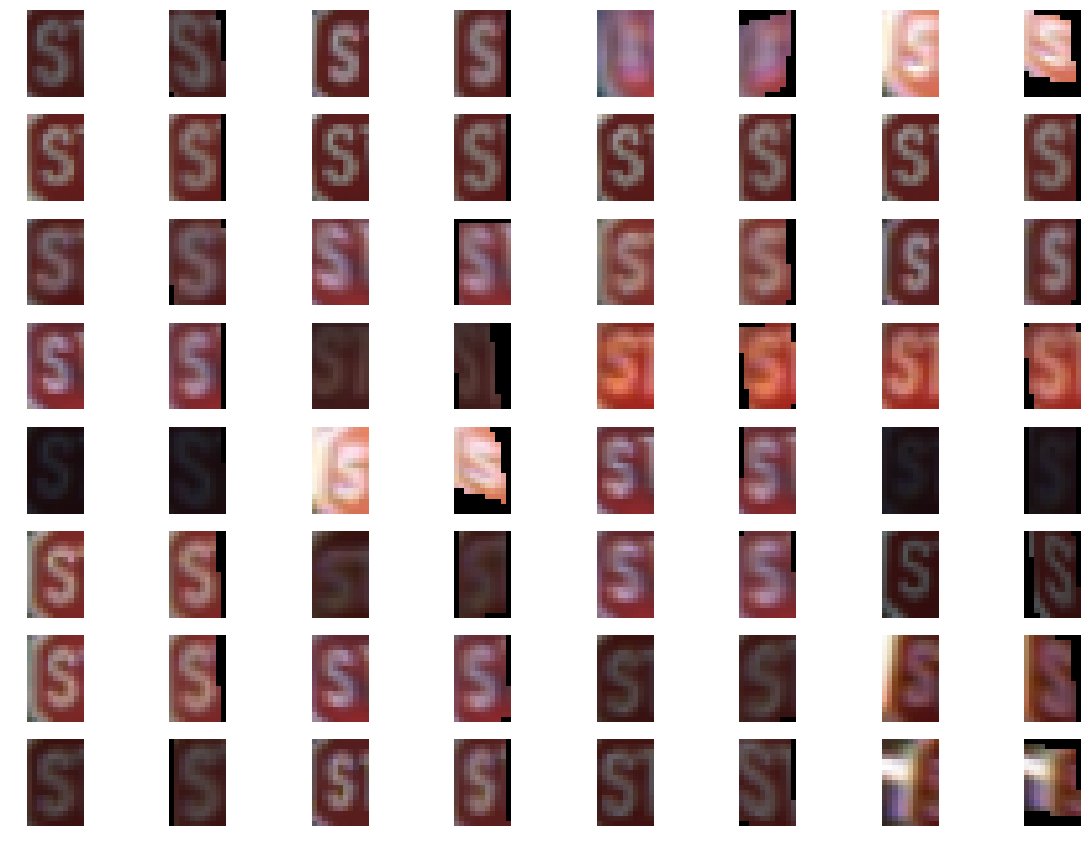

In [29]:
n_plt = 32
f, ax = plt.subplots(int(np.ceil(n_plt/4)), 8, figsize=(20, 15))
for i in range(n_plt):
    
    ii = i//4
    jj = (i % 4)*2

    ax[ii, jj].imshow(S[i])
    ax[ii, jj].axis("off")
    ax[ii, jj + 1].imshow(s[i])
    ax[ii, jj + 1].axis("off")

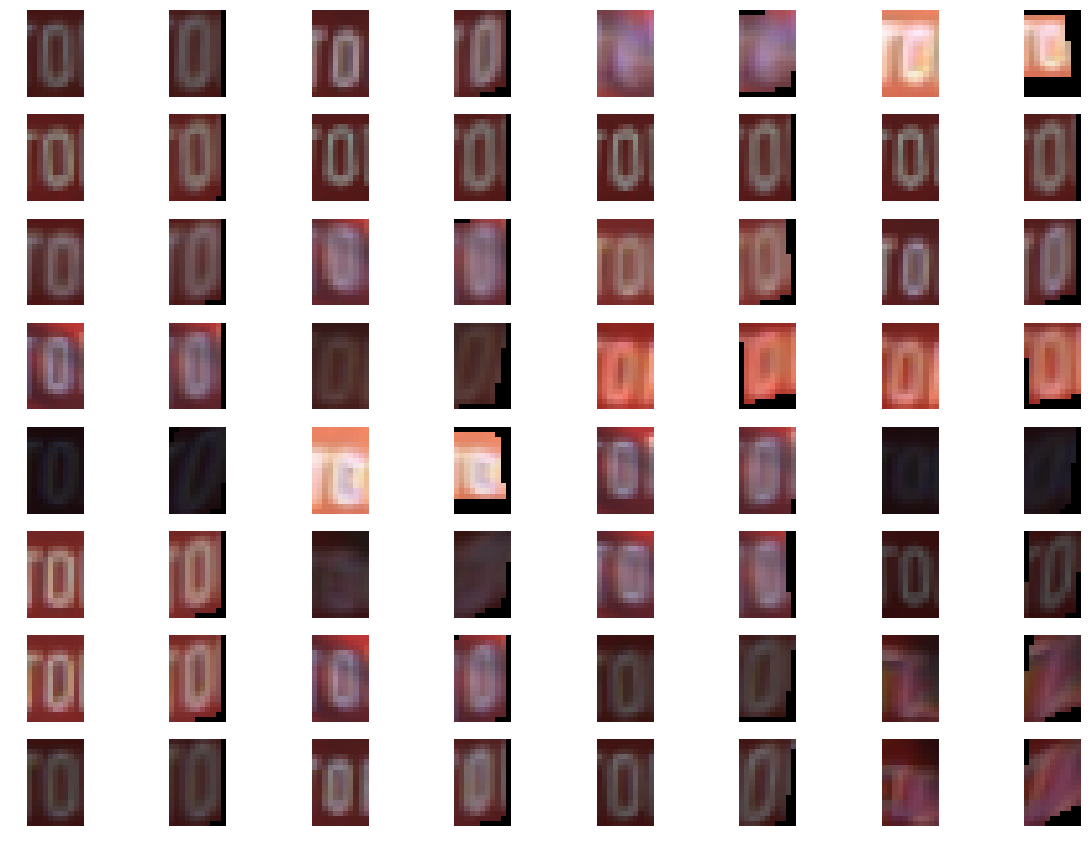

In [30]:
n_plt = 32
f, ax = plt.subplots(int(np.ceil(n_plt/4)), 8, figsize=(20, 15))
for i in range(n_plt):
    
    ii = i//4
    jj = (i % 4)*2

    ax[ii, jj].imshow(O[i])
    ax[ii, jj].axis("off")
    ax[ii, jj + 1].imshow(o[i])
    ax[ii, jj + 1].axis("off")

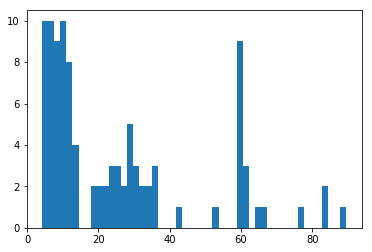

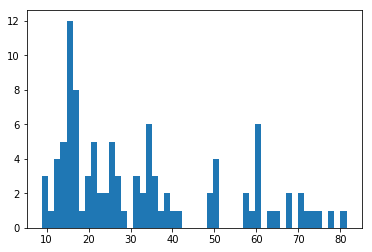

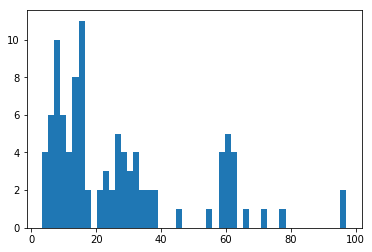

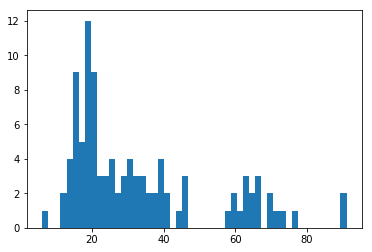

In [31]:
# S before transformation
dist = np.sum(np.square(S[:n] - x_mean).reshape(n, -1), axis=1)
plt.hist(dist, bins=50)
plt.show()

# S after transformation
dist = np.sum(np.square(s - x_mean).reshape(n, -1), axis=1)
plt.hist(dist, bins=50)
plt.show()

# O before 
dist = np.sum(np.square(O[:n] - x_mean).reshape(n, -1), axis=1)
plt.hist(dist, bins=50)
plt.show()

# O after transformation
dist = np.sum(np.square(o - x_mean).reshape(n, -1), axis=1)
plt.hist(dist, bins=50)
plt.show()

In [22]:
s.shape

(270, 17, 11, 3)

In [1]:
def hsv_dist(image_a, image_b):
    
    dist1 = np.square(image_a - image_b)
    dist2 = np.square(image_a + 1 - image_b)
    dist3 = np.square(image_a - image_b - 1)
    dist = np.minimum(dist1, dist2)
    return np.minimum(dist, dist3)

def hsv_mean(images):
    
    from scipy.stats import circmean
    out = np.zeros_like(images[0])
    out[:, :, :2] = np.mean(images[:, :, :, :2], axis=0)
    out[:, :, 2] = circmean(images[:, :, :, 2], high=1, low=0, axis=0)
    return out

In [2]:
# Convert to HSV
print("Mean of HSV image")
S = matplotlib.colors.rgb_to_hsv(S)
mean = hsv_mean(S)
plt.imshow(matplotlib.colors.hsv_to_rgb(mean))
plt.show()
    
# Sample that's closest to the mean
dist = np.sqrt(np.sum(np.square(S - mean).reshape(S.shape[0], -1), axis=1))
ind_center = np.argmin(dist)
print("Sample closest to the mean")
# x_mean = S[ind_center]
x_mean = S[80]
plt.imshow(matplotlib.colors.hsv_to_rgb(x_mean))
plt.show()
print("L2 dist from mean: {:.4f}".format(dist[ind_center]))
plt.hist(dist, bins=50)
plt.show()

NameError: name 'X_train' is not defined

### HSV - no offset

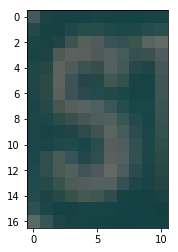

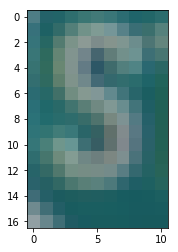

In [34]:
n = 100
X_S = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
S = matplotlib.colors.rgb_to_hsv(S)

# Offset
H = np.copy(S[:, :, :, 0])
S[H >= 0.5, 0] -= 0.5
S[H < 0.5, 0] += 0.5

O = get_patch(X_stn, pos_O)
O = matplotlib.colors.rgb_to_hsv(O)

H = np.copy(O[:, :, :, 0])
O[H >= 0.5, 0] -= 0.5
O[H < 0.5, 0] += 0.5

plt.imshow(matplotlib.colors.hsv_to_rgb(S[0]))
plt.show()

x_mean_H = np.copy(x_mean[:, :, 0])
x_mean[x_mean_H >= 0.5, 0] -= 0.5
x_mean[x_mean_H < 0.5, 0] += 0.5

plt.imshow(matplotlib.colors.hsv_to_rgb(x_mean))
plt.show()

# x_mean_H = np.copy(x_mean[:, :, 0])
# x_mean[x_mean_H >= 0.5, 0] -= 0.5
# x_mean[x_mean_H <= 0.5, 0] += 0.5

# plt.imshow(matplotlib.colors.hsv_to_rgb(x_mean))
# plt.show()

In [35]:
from lib.transformer import Transformer
sess = tf.get_default_session()
transformer = Transformer(S.shape[1:], sess=sess, batch_size=n, learning_rate=1e-3, hsv=False)

In [36]:
# Match with mean
templates = np.repeat(x_mean[np.newaxis], n, axis=0)
s = transformer.transform(S[:n], templates, n_steps=500)
s = np.clip(s, 0, 1)

o = transformer.transform(O[:n], templates, n_steps=500)
o = np.clip(o, 0, 1)

step: 0 - loss: 38.4861
step: 10 - loss: 43.1586
step: 20 - loss: 44.0255
step: 30 - loss: 44.3980
step: 40 - loss: 44.2269
step: 50 - loss: 43.9961
step: 60 - loss: 43.5769
step: 70 - loss: 42.8017
step: 80 - loss: 42.1620
step: 90 - loss: 41.5206
step: 100 - loss: 40.8226
step: 110 - loss: 39.6849
step: 120 - loss: 38.8587
step: 130 - loss: 38.1798
step: 140 - loss: 37.5146
step: 150 - loss: 36.8196
step: 160 - loss: 36.2882
step: 170 - loss: 35.8531
step: 180 - loss: 35.2588
step: 190 - loss: 34.8426
step: 200 - loss: 34.4466
step: 210 - loss: 33.9691
step: 220 - loss: 33.7641
step: 230 - loss: 33.6355
step: 240 - loss: 33.4092
step: 250 - loss: 33.2684
step: 260 - loss: 33.0529
step: 270 - loss: 32.9244
step: 280 - loss: 32.7799
step: 290 - loss: 32.5400
step: 300 - loss: 32.5806
step: 310 - loss: 32.4737
step: 320 - loss: 32.3928
step: 330 - loss: 32.3111
step: 340 - loss: 32.1924
step: 350 - loss: 32.1523
step: 360 - loss: 32.1956
step: 370 - loss: 32.1780
step: 380 - loss: 32.17

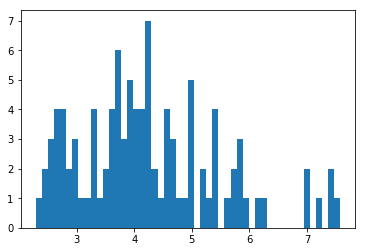

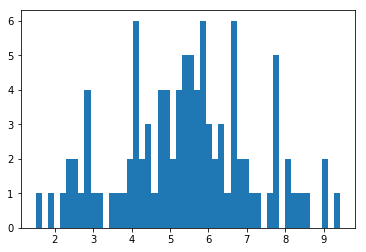

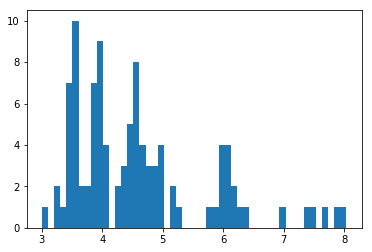

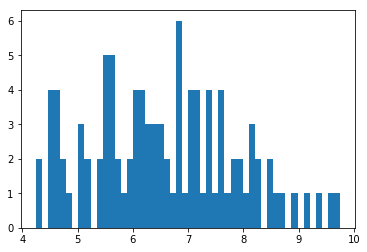

In [38]:
# S before transformation
dist = np.sqrt(np.sum(np.square(S[:n] - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

# S after transformation
dist = np.sqrt(np.sum(np.square(s - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

# O before 
dist = np.sqrt(np.sum(np.square(O[:n] - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

# O after transformation
dist = np.sqrt(np.sum(np.square(o - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

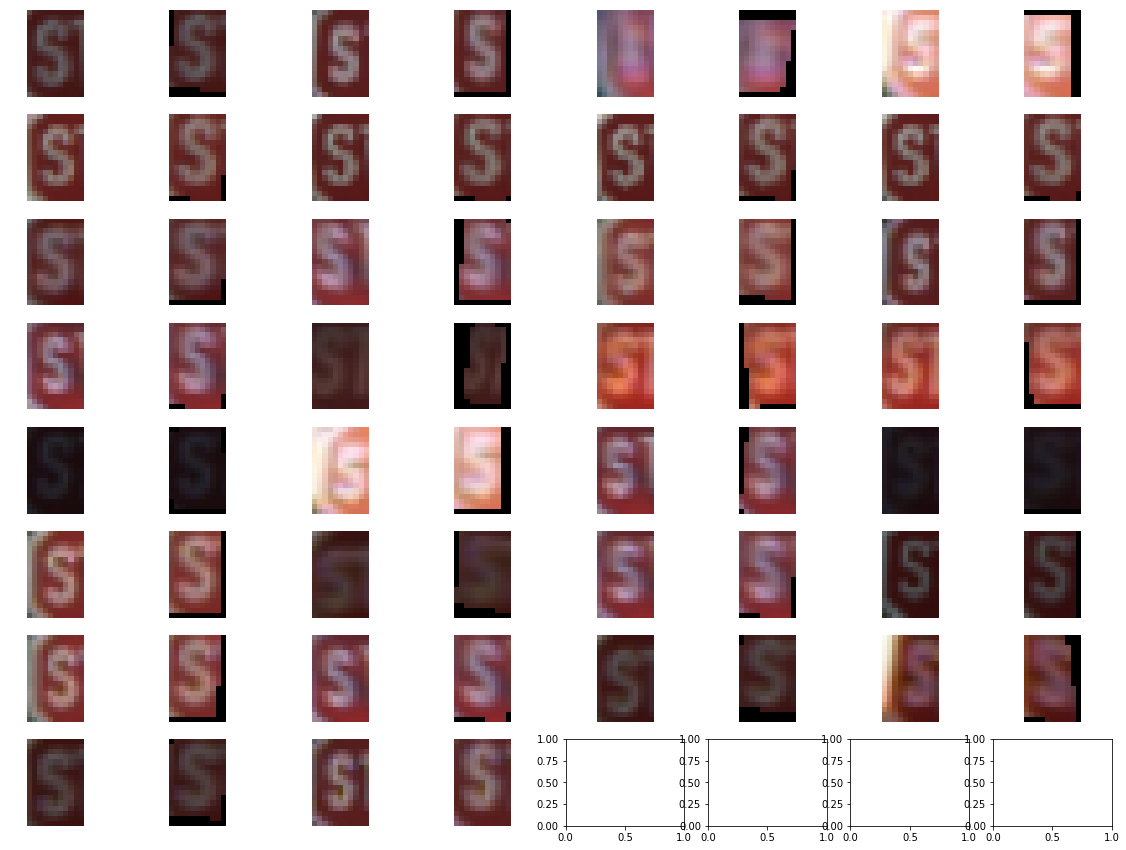

In [39]:
H = np.copy(S[:, :, :, 0])
S[H >= 0.5, 0] -= 0.5
S[H < 0.5, 0] += 0.5

s_H = np.copy(s[:, :, :, 0])
s[s_H >= 0.5, 0] -= 0.5
s[s_H < 0.5, 0] += 0.5

n_plt = 30
f, ax = plt.subplots(int(np.ceil(n_plt/4)), 8, figsize=(20, 15))
for i in range(n_plt):
    
    ii = i//4
    jj = (i % 4)*2

    ax[ii, jj].imshow(matplotlib.colors.hsv_to_rgb(S[i]))
    ax[ii, jj].axis("off")
    ax[ii, jj + 1].imshow(matplotlib.colors.hsv_to_rgb(s[i]))
    ax[ii, jj + 1].axis("off")

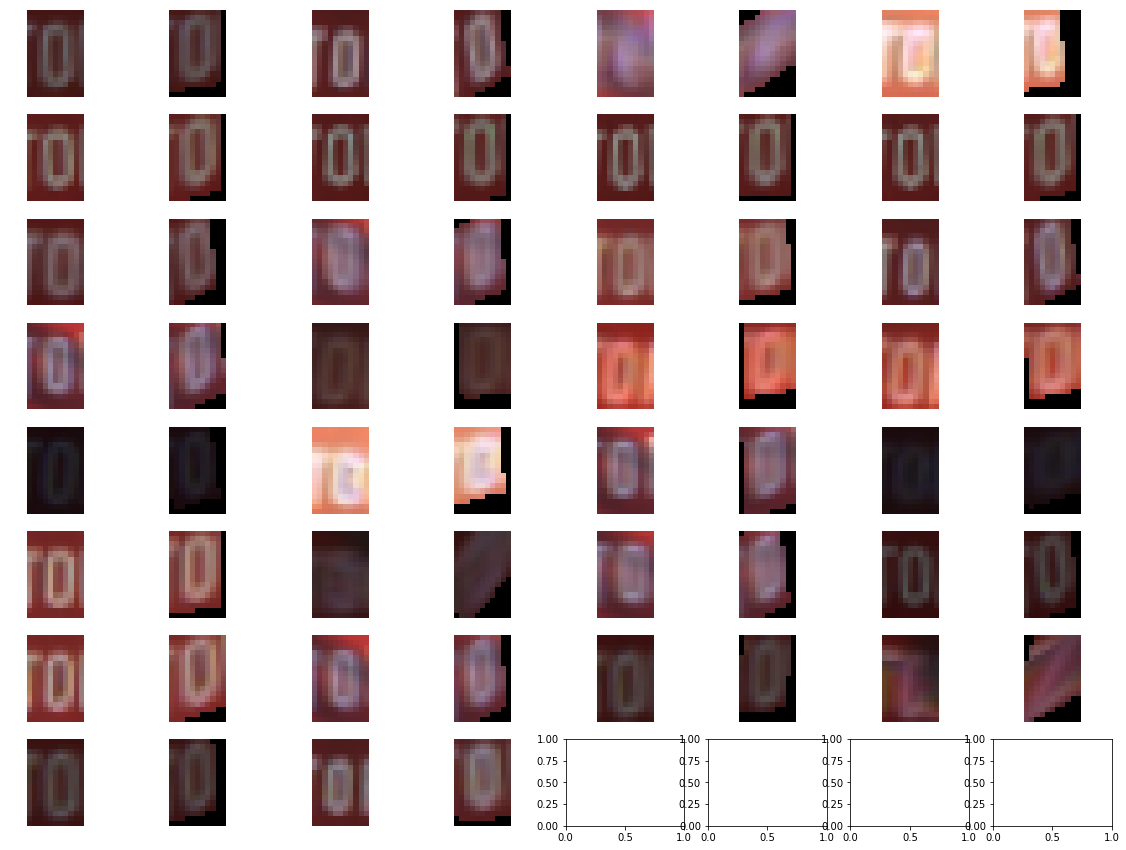

In [40]:
H = np.copy(O[:, :, :, 0])
O[H >= 0.5, 0] -= 0.5
O[H < 0.5, 0] += 0.5

o_H = np.copy(o[:, :, :, 0])
o[o_H >= 0.5, 0] -= 0.5
o[o_H < 0.5, 0] += 0.5

n_plt = 30
f, ax = plt.subplots(int(np.ceil(n_plt/4)), 8, figsize=(20, 15))
for i in range(n_plt):
    
    ii = i//4
    jj = (i % 4)*2

    ax[ii, jj].imshow(matplotlib.colors.hsv_to_rgb(O[i]))
    ax[ii, jj].axis("off")
    ax[ii, jj + 1].imshow(matplotlib.colors.hsv_to_rgb(o[i]))
    ax[ii, jj + 1].axis("off")

### HSV - no offset, only H channel

In [43]:
X_S = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
S = matplotlib.colors.rgb_to_hsv(S)
x_mean = S[80]

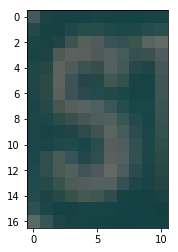

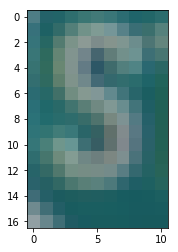

In [44]:
n = 100
X_S = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
S = matplotlib.colors.rgb_to_hsv(S)

# Offset
H = np.copy(S[:, :, :, 0])
S[H >= 0.5, 0] -= 0.5
S[H < 0.5, 0] += 0.5

O = get_patch(X_stn, pos_O)
O = matplotlib.colors.rgb_to_hsv(O)

H = np.copy(O[:, :, :, 0])
O[H >= 0.5, 0] -= 0.5
O[H < 0.5, 0] += 0.5

plt.imshow(matplotlib.colors.hsv_to_rgb(S[0]))
plt.show()

x_mean_H = np.copy(x_mean[:, :, 0])
x_mean[x_mean_H >= 0.5, 0] -= 0.5
x_mean[x_mean_H < 0.5, 0] += 0.5

plt.imshow(matplotlib.colors.hsv_to_rgb(x_mean))
plt.show()

In [47]:
x_mean = x_mean[:, :, :1]
S = S[:, :, :, :1]
O = O[:, :, :, :1]

In [49]:
from lib.transformer import Transformer
sess = tf.get_default_session()
transformer = Transformer(S.shape[1:], sess=sess, batch_size=n, learning_rate=1e-3, hsv=False)

# Match with mean
templates = np.repeat(x_mean[np.newaxis], n, axis=0)
s = transformer.transform(S[:n], templates, n_steps=500)
s = np.clip(s, 0, 1)

o = transformer.transform(O[:n], templates, n_steps=500)
o = np.clip(o, 0, 1)

step: 0 - loss: 7.6292
step: 10 - loss: 9.4106
step: 20 - loss: 9.9370
step: 30 - loss: 10.3831
step: 40 - loss: 10.5318
step: 50 - loss: 10.6176
step: 60 - loss: 10.5908
step: 70 - loss: 10.6393
step: 80 - loss: 10.7110
step: 90 - loss: 10.7661
step: 100 - loss: 10.8370
step: 110 - loss: 10.8869
step: 120 - loss: 10.8924
step: 130 - loss: 10.9445
step: 140 - loss: 10.9577
step: 150 - loss: 10.9789
step: 160 - loss: 10.9974
step: 170 - loss: 11.0390
step: 180 - loss: 11.0051
step: 190 - loss: 10.9767
step: 200 - loss: 11.0180
step: 210 - loss: 11.0457
step: 220 - loss: 11.1023
step: 230 - loss: 11.0975
step: 240 - loss: 11.0905
step: 250 - loss: 11.0783
step: 260 - loss: 11.0784
step: 270 - loss: 11.0684
step: 280 - loss: 11.0934
step: 290 - loss: 11.0745
step: 300 - loss: 11.1006
step: 310 - loss: 11.1282
step: 320 - loss: 11.1295
step: 330 - loss: 11.1579
step: 340 - loss: 11.1936
step: 350 - loss: 11.2175
step: 360 - loss: 11.2526
step: 370 - loss: 11.2680
step: 380 - loss: 11.2734


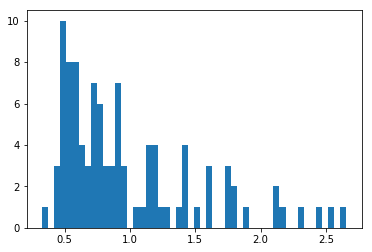

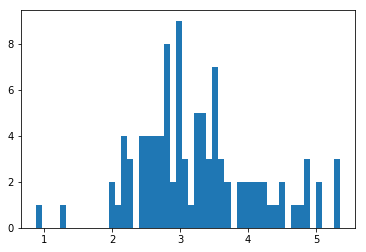

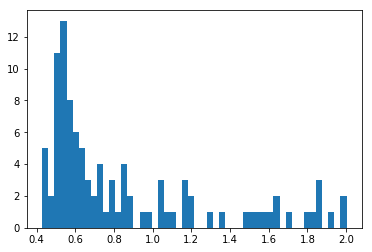

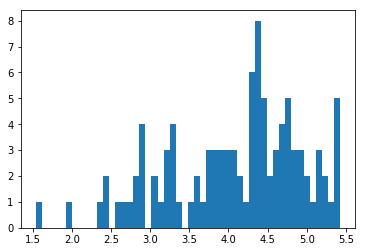

In [50]:
# S before transformation
dist = np.sqrt(np.sum(np.square(S[:n] - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

# S after transformation
dist = np.sqrt(np.sum(np.square(s - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

# O before 
dist = np.sqrt(np.sum(np.square(O[:n] - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

# O after transformation
dist = np.sqrt(np.sum(np.square(o - x_mean).reshape(n, -1), axis=1))
plt.hist(dist, bins=50)
plt.show()

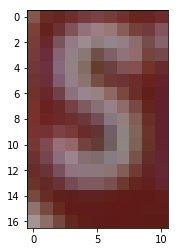

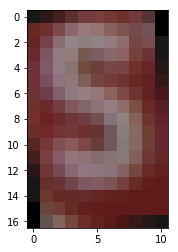

In [7]:
X_S = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
x_mean = S[80]
plt.imshow(x_mean)
plt.show()

import skimage.transform

rotate = skimage.transform.rotate(x_mean, 10)
plt.imshow(rotate)
plt.show()

In [48]:
# from lib.transformer import Transformer
# from lib.transformer_tf import Transformer
from lib.transformer_tf_v2 import Transformer

sess = tf.get_default_session()
transformer = Transformer(S.shape[1:], sess=sess, batch_size=1, 
                          learning_rate=1e-3, hsv=False)

# Match with mean
templates = np.repeat(x_mean[np.newaxis], 1, axis=0)
s = transformer.transform(rotate[np.newaxis], templates, n_steps=200)
s = np.clip(s, 0, 1)

step: 0 - loss: 12.6323
step: 10 - loss: 15.7355
step: 20 - loss: 15.0929
step: 30 - loss: 14.5926
step: 40 - loss: 14.2202
step: 50 - loss: 14.2793
step: 60 - loss: 13.4534
step: 70 - loss: 12.5571
step: 80 - loss: 13.0655
step: 90 - loss: 13.4411
step: 100 - loss: 12.5187
step: 110 - loss: 10.1157
step: 120 - loss: 8.8903
step: 130 - loss: 8.4472
step: 140 - loss: 7.8845
step: 150 - loss: 7.7174
step: 160 - loss: 7.3891
step: 170 - loss: 7.2994
step: 180 - loss: 7.2335
step: 190 - loss: 6.9130


In [15]:
np.sum(np.square(templates - x_mean))

0.0

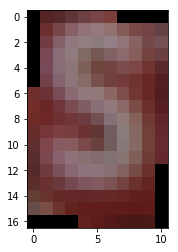

In [49]:
plt.imshow(s[0])
plt.show()

In [33]:
# Correct implementation
n = 100
X_S = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)

In [37]:
from lib.transformer import Transformer
sess = tf.get_default_session()
transformer = Transformer(S.shape[1:], sess=sess, batch_size=n, learning_rate=1e-3, hsv=True)

In [38]:
# Match with mean
templates = np.repeat(mean[np.newaxis], n, axis=0)
x = transformer.transform(S[:n], templates, n_steps=500)
x = np.clip(x, 0, 1)

step: 0 - loss: 19.6465
step: 1 - loss: 20.3624
step: 2 - loss: 20.3489
step: 3 - loss: 20.3090
step: 4 - loss: 20.2919
step: 5 - loss: 20.2740
step: 6 - loss: 20.2680
step: 7 - loss: 20.2747
step: 8 - loss: 20.2896
step: 9 - loss: 20.3212
step: 10 - loss: 20.3423
step: 11 - loss: 20.3913
step: 12 - loss: 20.4086
step: 13 - loss: 20.4263
step: 14 - loss: 20.4424
step: 15 - loss: 20.4700
step: 16 - loss: 20.4774
step: 17 - loss: 20.4773
step: 18 - loss: 20.4832
step: 19 - loss: 20.4915
step: 20 - loss: 20.4984
step: 21 - loss: 20.5095
step: 22 - loss: 20.5074
step: 23 - loss: 20.5179
step: 24 - loss: 20.5044
step: 25 - loss: 20.4962
step: 26 - loss: 20.4956
step: 27 - loss: 20.5039
step: 28 - loss: 20.5149
step: 29 - loss: 20.5112
step: 30 - loss: 20.4961
step: 31 - loss: 20.4834
step: 32 - loss: 20.4682
step: 33 - loss: 20.4753
step: 34 - loss: 20.4793
step: 35 - loss: 20.4682
step: 36 - loss: 20.4686
step: 37 - loss: 20.4740
step: 38 - loss: 20.4832
step: 39 - loss: 20.4765
step: 40 -

step: 367 - loss: 18.3636
step: 368 - loss: 18.3570
step: 369 - loss: 18.3587
step: 370 - loss: 18.3601
step: 371 - loss: 18.3629
step: 372 - loss: 18.3891
step: 373 - loss: 18.3658
step: 374 - loss: 18.3567
step: 375 - loss: 18.3630
step: 376 - loss: 18.3684
step: 377 - loss: 18.3694
step: 378 - loss: 18.3862
step: 379 - loss: 18.3752
step: 380 - loss: 18.3664
step: 381 - loss: 18.3624
step: 382 - loss: 18.3661
step: 383 - loss: 18.3732
step: 384 - loss: 18.3738
step: 385 - loss: 18.3954
step: 386 - loss: 18.3831
step: 387 - loss: 18.3761
step: 388 - loss: 18.3830
step: 389 - loss: 18.3825
step: 390 - loss: 18.3857
step: 391 - loss: 18.3899
step: 392 - loss: 18.3876
step: 393 - loss: 18.3868
step: 394 - loss: 18.4007
step: 395 - loss: 18.4046
step: 396 - loss: 18.3878
step: 397 - loss: 18.3888
step: 398 - loss: 18.3941
step: 399 - loss: 18.3936
step: 400 - loss: 18.3894
step: 401 - loss: 18.3896
step: 402 - loss: 18.3848
step: 403 - loss: 18.3845
step: 404 - loss: 18.4031
step: 405 - 

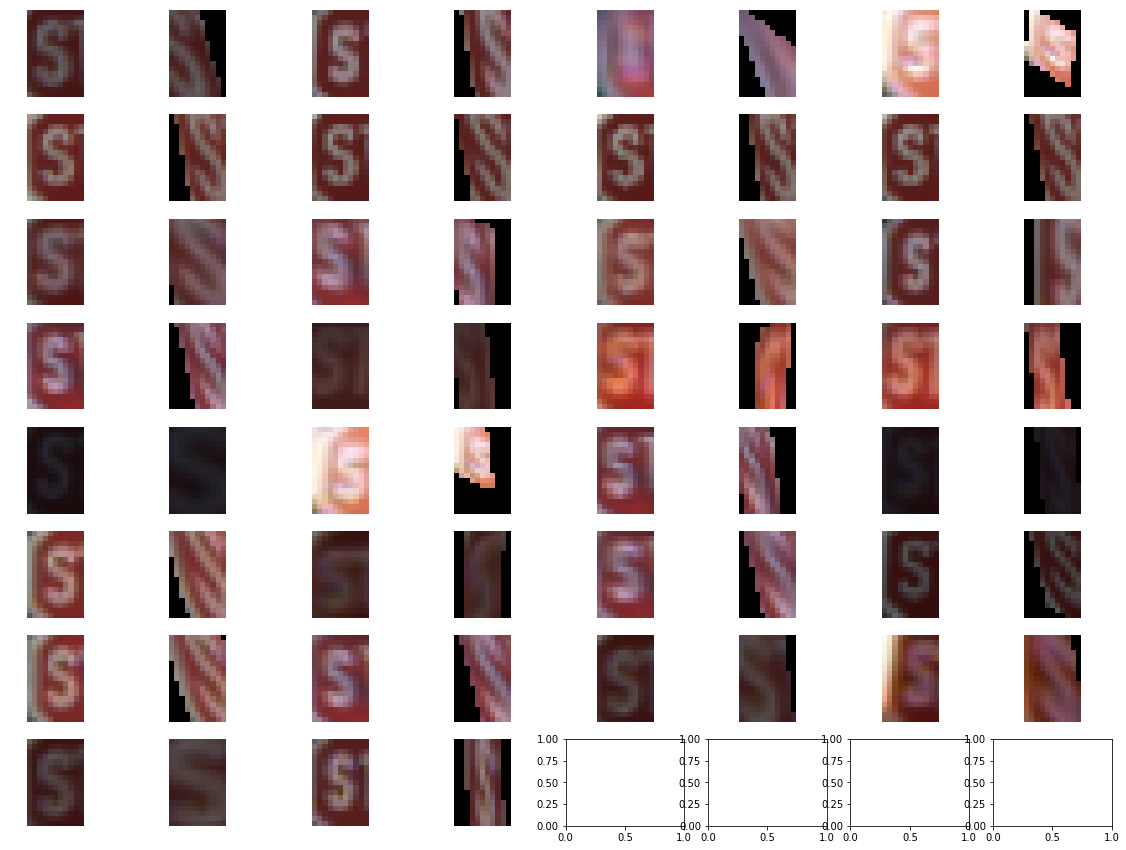

In [39]:
n_plt = 30
f, ax = plt.subplots(int(np.ceil(n_plt/4)), 8, figsize=(20, 15))
for i in range(n_plt):
    
    ii = i//4
    jj = (i % 4)*2

    ax[ii, jj].imshow(S[i])
    ax[ii, jj].axis("off")
    ax[ii, jj + 1].imshow(x[i])
    ax[ii, jj + 1].axis("off")

---
## Test robustness

In [24]:
# Load and set up all models
clf = conv_model_no_color_adjust()
clf.load_weights("./keras_weights/stn_v5.hdf5")
stn_weight = clf.layers[1].get_weights()
get_stn_output = K.function([clf.layers[0].input, K.learning_phase()],
                            [clf.layers[1].output])
detect_3 = create_simple_cnn(pos_3, stn_weight)
detect_3.load_weights("./keras_weights/1_3.hdf5")
detect_S = create_simple_cnn(pos_S, stn_weight)
detect_S.load_weights("./keras_weights/14_S.hdf5")

In [34]:
detect_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
spatial_transformer_5 (Spati (None, 32, 32, 3)         294794    
_________________________________________________________________
cropping2d_6 (Cropping2D)    (None, 17, 11, 3)         0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 17, 11, 3)         12        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 15, 9, 16)         448       
_________________________________________________________________
batch_normalization_33 (Batc (None, 15, 9, 16)         64        
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 13, 7, 32)         4640      
__________

In [39]:
from lib.white_box_attack import CarliniWagnerL2_WB

